# FaceSim – Results

Notebook to summarize results of the `FaceSim` study.

    Author: Simon M. Hofmann
    Years: 2023-2024

## Setup
### Imports

In [1]:
import warnings
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
import statsmodels.api as sm
from facesim3d.configs import params, paths
from facesim3d.datachecks import prob_catch_trials
from facesim3d.modeling.compute_similarity import compute_pearson_correlation_between_two_feature_matrices
from facesim3d.modeling.face_attribute_processing import (
    cfd_var_converter,
    get_cfd_features_for_models,
    heads_naming_converter_table,
    main_index_to_model_name,
)
from facesim3d.modeling.prep_computational_choice_model import (
    list_spose_model_performances,
    list_vice_model_performances,
    load_best_vice_weights,
)

# from facesim3d.modeling.compute_noise_ceiling import get_mer_table # noqa: ERA001
from facesim3d.modeling.rsa import (
    METRIC,
    SPEARMAN,
    aggregate_judgments_in_session,
    get_corr_df_rsm,
    vectorize_similarity_matrix,
)
from facesim3d.modeling.VGG.vgg_predict import get_vgg_performance_table
from facesim3d.read_data import (
    COMPLETION_CODES,
    create_all_triple_combinations,
    get_list_of_acquired_sets,
    read_prolific_participant_data,
    read_trial_results_of_session,
)
from IPython.display import Image
from IPython.display import display as dspl
from scipy.stats import pearsonr, ttest_ind
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from ut.ils import cprint

# Suppress specific warnings
warnings.filterwarnings(
    "ignore", message="The identity link function does not respect the domain of the InverseGaussian family."
)


***********************************************************************************************
***********************************************************************************************

										🗿FaceSim3D 🗿

***********************************************************************************************
***********************************************************************************************




### Set variables and paths

In [2]:
# For RSA
CORR_NAME = "Spearman" if SPEARMAN else "Pearson"

# Results

## General stats
### Participants

In [3]:
# Number of participants that took part
sub_sample = ("both", "main", "mss")[0]  # toggle main: main sample; mss: multi_sub_sample
all_ppid_ages = []  # init
for session in params.SESSIONS:
    print()
    ppid_ages = []  # init
    n_female = 0  # init
    n_male = 0  # init
    n_ppid = 0  # init for each session
    n_commpleted = 0  # init
    n_failed = 0  # init
    n_no_code = 0  # init
    n_unknown_code = 0  # init
    for set_nr in get_list_of_acquired_sets():
        if not set_nr.startswith(session[0]):
            continue

        if (sub_sample == "mss" and set_nr.split(".")[-1] != "20") or (
            sub_sample == "main" and set_nr.split(".")[-1] == "20"
        ):
            continue

        pid_table2 = read_prolific_participant_data(set_nr, return_path=False)
        ppid_ages += pid_table2.Age.astype(str).to_list()
        n_ppid += len(pid_table2)
        n_female += sum(pid_table2.Sex == "Female")
        n_male += sum(pid_table2.Sex == "Male")

        for code, tab in pid_table2.groupby("Completion code"):
            code_name = [k for k, v in COMPLETION_CODES.items() for c in v.values() if c == code]
            code_name = code_name.pop() if code_name else code

            if "complet" in code_name:
                n_commpleted += len(tab)
            elif code_name == "failed":
                n_failed += len(tab)
            elif code_name == "NOCODE":
                n_no_code += len(tab)
            else:
                n_unknown_code += len(tab)

            # cprint(f"Code: '{code_name}' | n = {len(tab)}", col="y", fm="ul") # noqa: ERA001
            # print(tab[["Nationality", "Time taken"]]) # noqa: ERA001
            # print() # noqa: ERA001
    ppid_ages = [int(a) for a in ppid_ages if a not in {"CONSENT_REVOKED", "DATA_EXPIRED"}]
    all_ppid_ages += ppid_ages

    # Note: n_ppid == n_commpleted + n_commpleted + n_no_code + n_unknown_code  # noqa: ERA001
    cprint(
        f"Number of participants that took part in session {session}: {n_ppid} "
        f"(n_female = {n_female}, n_male = {n_male}, n_unknown = {n_ppid - (n_female + n_male)})",
        col="b",
        fm="bo",
    )
    print(
        f"Age of participants in session {session}: range = {np.min(ppid_ages)} - {np.max(ppid_ages)}, "
        f"mean = {np.mean(ppid_ages):.2f} ± {np.std(ppid_ages):.2f} SD years\n"
    )
    cprint(f"Number of participants that completed the task in session {session}: {n_commpleted}\n", col="g", fm="bo")
    cprint(
        f"Number of participants that failed the attention checks in session {session}: {n_failed}\n", col="r", fm="bo"
    )
    cprint(f"Number of participants that entered NO CODE in session {session}: {n_no_code}\n", col="y", fm="bo")
    cprint(
        f"Number of participants that entered unknown code in session {session}: {n_unknown_code}\n", col="y", fm="bo"
    )
    print("*-" * 40 + "*")
print(
    f"Age of all participants: range = {np.min(all_ppid_ages)} - {np.max(all_ppid_ages)}, "
    f"mean = {np.mean(all_ppid_ages):.2f} ± {np.std(all_ppid_ages):.2f} SD years\n"
)


Number of participants that took part in session 2D: 1530 (n_female = 714, n_male = 716, n_unknown = 100)
Age of participants in session 2D: range = 19 - 65, mean = 31.27 ± 10.75 SD years

Number of participants that completed the task in session 2D: 1397

Number of participants that failed the attention checks in session 2D: 104

Number of participants that entered NO CODE in session 2D: 21

Number of participants that entered unknown code in session 2D: 8

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Number of participants that took part in session 3D: 1414 (n_female = 667, n_male = 662, n_unknown = 85)
Age of participants in session 3D: range = 18 - 65, mean = 32.57 ± 11.24 SD years

Number of participants that completed the task in session 3D: 1313

Number of participants that failed the attention checks in session 3D: 78

Number of participants that entered NO CODE in session 3D: 22

Number of participants that entered unknown code in session

### Trials excluded

In [4]:
# When clicking randomly there is a minimal chance to pass the attention checks

cprint("\nPprobabity being caught < 3 times across the whole experiment", fm="ul")
prob_catch_trials(r=params.quality.MAX_CATCH - 1, n=params.n_catch_trials, verbose=False)  # params.n_catch_trials == 3

cprint("\nProbabity being not caught in one block", fm="ul")
prob_catch_trials(r=0, n=params.n_catch_trials // 3, verbose=False)  # n = 3


Pprobabity being caught < 3 times across the whole experiment
The chance of having less than 3 catch(es) in 9 catch-trials is: 0.83%

Probabity being not caught in one block
The chance of having less than 1 catch(es) in 3 catch-trials is: 3.70%


In [5]:
tr_table_2d = read_trial_results_of_session(session="2D", clean_trials=True, drop_subsamples=True, verbose=False)
print(f"Number of trials after cleaning in session 2D: {len(tr_table_2d)}")
print(f"Number of participants after cleaning in session 2D: {tr_table_2d.ppid_session_dataname.nunique()}")
tr_table_3d = read_trial_results_of_session(session="3D", clean_trials=True, drop_subsamples=True, verbose=False)
print(f"Number of trials after cleaning in session 3D: {len(tr_table_3d)}")
print(f"Number of participants after cleaning in session 3D: {tr_table_3d.ppid_session_dataname.nunique()}")

Clean trial results table: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 951.47it/s]


Number of trials after cleaning in session 2D: 194261
Number of participants after cleaning in session 2D: 1346


Clean trial results table: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 692.98it/s]


Number of trials after cleaning in session 3D: 185473
Number of participants after cleaning in session 3D: 1259


In [6]:
tr_tables = {"2D": tr_table_2d, "3D": tr_table_3d}
for session in tr_tables:
    # Add session information as column
    tr_tables[session]["session"] = session
tr_tables_df = tr_tables["2D"].append(tr_tables["3D"])

In [7]:
# Determine the amounts of exluded trials
for session in params.SESSIONS:
    cprint(f"\n{session} Session:", fm="ul")
    trials_all = read_trial_results_of_session(
        session=session, clean_trials=False, drop_subsamples=True, verbose=False
    )

    # Remove trials that should not flow into calculation:
    # Remove training trials
    trials_all = trials_all[trials_all.block_num > 1]

    # Remove catch trials
    trials_all = trials_all[trials_all.catch_head == 0]

    trials_clean = read_trial_results_of_session(
        session=session, clean_trials=True, drop_subsamples=True, verbose=False
    )

    perc_removed = 1 - len(trials_clean) / len(trials_all)  # ignore training trials
    cprint(f"In session {session} {perc_removed:.1%} of trials were removed.", col="y")


2D Session:
In session 2D 18.5% of trials were removed.

3D Session:
In session 3D 16.9% of trials were removed.


## Response times

In [8]:
def cohend(d1: np.ndarray, d2: np.ndarray) -> float:
    """Calculate Cohen's d for independent samples."""
    # calculate the pooled standard deviation
    s = np.sqrt(((len(d1) - 1) * np.var(d1, ddof=1) + (len(d2) - 1) * np.var(d2, ddof=1)) / (len(d1) + len(d2) - 2))
    return (np.mean(d1) - np.mean(d2)) / s  # effect size


Response time for session 2D:
count    194261.000000
mean          3.479793
std           1.498887
min           0.651300
25%           2.374800
50%           3.098500
75%           4.214500
max           9.999999
Name: response_time, dtype: float64

Response time for session 3D:
count    185473.000000
mean          3.543740
std           1.496115
min           0.633200
25%           2.433000
50%           3.169599
75%           4.299999
max           9.999999
Name: response_time, dtype: float64

ttest(rt_2d, rt_3d): t-statistic: -13.15, p-value <= 1.66e-39
Cohen's d: -0.043
                 Generalized Linear Model Regression Results                  
Dep. Variable:          response_time   No. Observations:               379734
Model:                            GLM   Df Residuals:                   379732
Model Family:         InverseGaussian   Df Model:                            1
Link Function:               identity   Scale:                        0.051843
Method:               

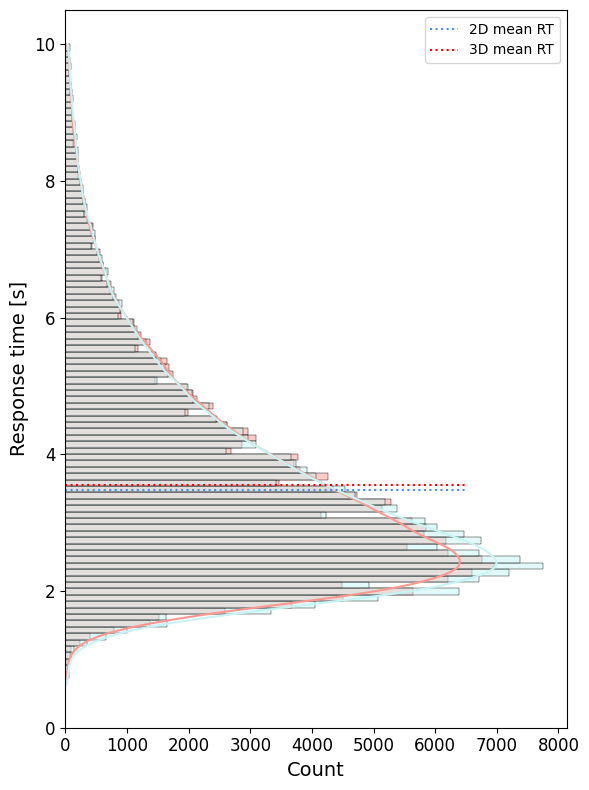

In [9]:
# Loop over sessions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 8))
add_mean_lines = True
session_colors = {"2D": "#C7F4F4", "3D": "#FF9891"}
session_lines = {"2D": "#468FF6", "3D": "red"}

ax = sns.histplot(
    data=tr_tables_df,
    y="response_time",
    hue="session",
    kde=True,
    bins=100,
    palette=session_colors,
    fill=True,
    ax=ax,
    linewidth=0.3,
    legend=False,
)
# add horizontal lines for mean RT
for session, tr_table in tr_tables.items():
    if add_mean_lines:
        ax.hlines(
            tr_table.response_time.mean(),
            0,
            ax.get_xlim()[1] * 0.8,
            colors=session_lines[session],
            linestyles="dotted",
            label=f"{session} mean RT",
        )
    print(f"\nResponse time for session {session}:")
    print(tr_table.response_time.describe())
ax.set_xlabel("Count", fontsize=14)
ax.set_ylabel("Response time [s]", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim(0, 10.5)
ax.legend()
plt.tight_layout()

for fmt in ["png", "pdf"]:
    plt.savefig(Path(paths.results.main.rt, f"rt.{fmt}"), dpi=300)

# First, simple t-test
t_stat, p_value = ttest_ind(
    a=tr_table_2d.response_time, b=tr_table_3d.response_time, alternative="two-sided", equal_var=True
)

print(f"\nttest(rt_2d, rt_3d): t-statistic: {t_stat:.2f}, p-value <= {p_value:.3g}")
print(f"Cohen's d: {cohend(tr_table_2d.response_time, tr_table_3d.response_time):.3f}")

# Run regression analysis using a GLM with inverse gaussian distribution (see: DOI:10.3389/fpsyg.2015.01171)
formula = "response_time ~ C(session)"
y, x = patsy.dmatrices(formula, data=tr_tables_df)
model = sm.GLM(y, x, family=sm.families.InverseGaussian(link=sm.families.links.identity()))
# default link = sm.families.links.inverse_squared()
# identity as link function is fine (see reference above)
# GLMM with random effect for PPID is not applicable here, because PPIDs do not overlap between sessions
result = model.fit()
print(result.summary())  # .as_text()
# Note, the interpretation of intercept & coefficients is not straightforward for inverse gaussian distribution
# with inverse squared link function
# Intercept = 0.0826 == tr_tables["2D"].response_time.mean()**-2 (inverse square of mean RT)
# Coeff (3D) = -0.0030 -> 3D RT is higher/slower than 2D RT
# Pseudo R-squ. (CS) = 0.0004551 means that effect is very small
# To be more correct, one needs to fit a mixed-effect model (GLMM), were PPID is a random effect
# response_time ~ session + 1|ppid

### Correlate response times of triplet ID's between sessions

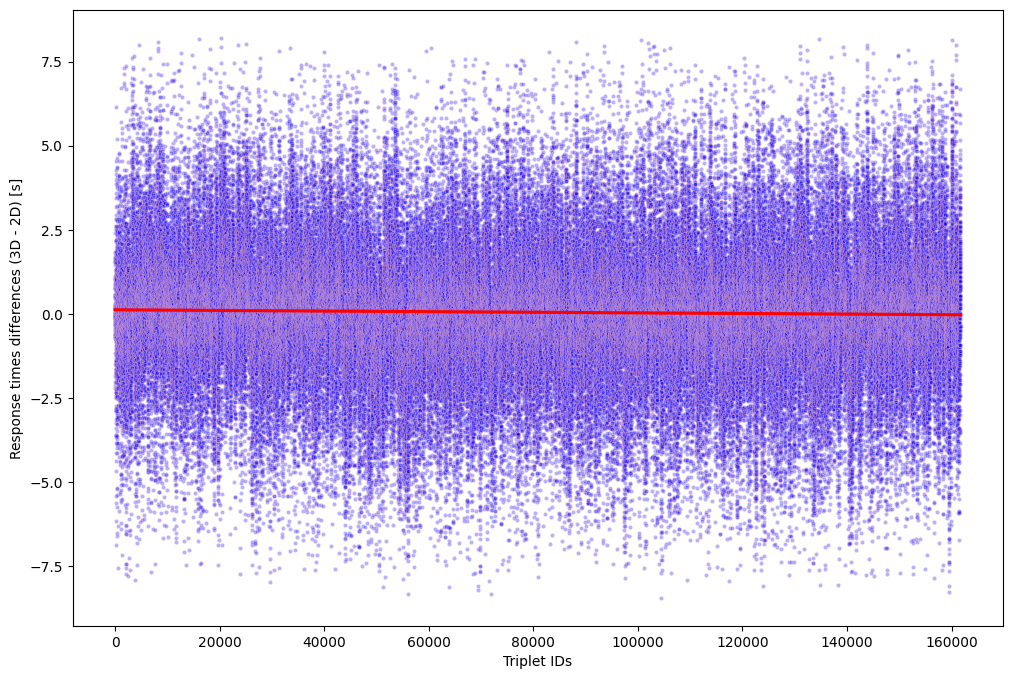

In [10]:
# Semi-randomly take 1 from triplet IDs that were sampled multiple times
tr_table_2d_unique = tr_table_2d.iloc[tr_table_2d.triplet_id.drop_duplicates().index]
tr_table_3d_unique = tr_table_3d.iloc[tr_table_3d.triplet_id.drop_duplicates().index]

# Sort by triplet_id
tr_table_2d_unique = tr_table_2d_unique.sort_values(by="triplet_id").reset_index(drop=True)
tr_table_3d_unique = tr_table_3d_unique.sort_values(by="triplet_id").reset_index(drop=True)
# ttest_rel(a=tr_table_2d_unique.response_time, b=tr_table_3d_unique.response_time)  # noqa: ERA001

plt.figure(num="rt_2d_3d", figsize=(12, 8))
sns.regplot(
    x=tr_table_3d_unique.triplet_id,
    y=tr_table_3d_unique.response_time - tr_table_2d_unique.response_time,
    scatter_kws={"color": "blue", "alpha": 0.3, "s": 8, "edgecolor": "pink", "linewidths": 0.5},
    line_kws={"color": "red"},
)
plt.xlabel("Triplet IDs")
_ = plt.ylabel("Response times differences (3D - 2D) [s]")  # _ = : avoid output
# r, p_value = pearsonr(tr_table_2d_unique.response_time, tr_table_3d_unique.response_time)  # noqa: ERA001
# print(f"\nPearson correlation(rt_2d, rt_3d): r: {r:.2f}, p-value <= {p_value:.3g}")  # noqa: ERA001

### Response times as function of similarity

pearsonr(sim ~ RT) (order=1): PearsonRResult(statistic=0.23160084101455494, pvalue=2.8385370557883092e-61)
pearsonr(sim ~ RT) (order=2): PearsonRResult(statistic=0.22948643784766498, pvalue=3.658911721046632e-60)
pearsonr(sim ~ RT) (order=1): PearsonRResult(statistic=0.26796668659180756, pvalue=3.6611021617578353e-82)
pearsonr(sim ~ RT) (order=2): PearsonRResult(statistic=0.2649071451455536, pvalue=2.845448723742933e-80)
2D
                            OLS Regression Results                            
Dep. Variable:          response_time   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     280.4
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           2.84e-61
Time:                        15:02:07   Log-Likelihood:                 1586.2
No. Observations:                4950   AIC:                            -3168.
Df Residuals:      

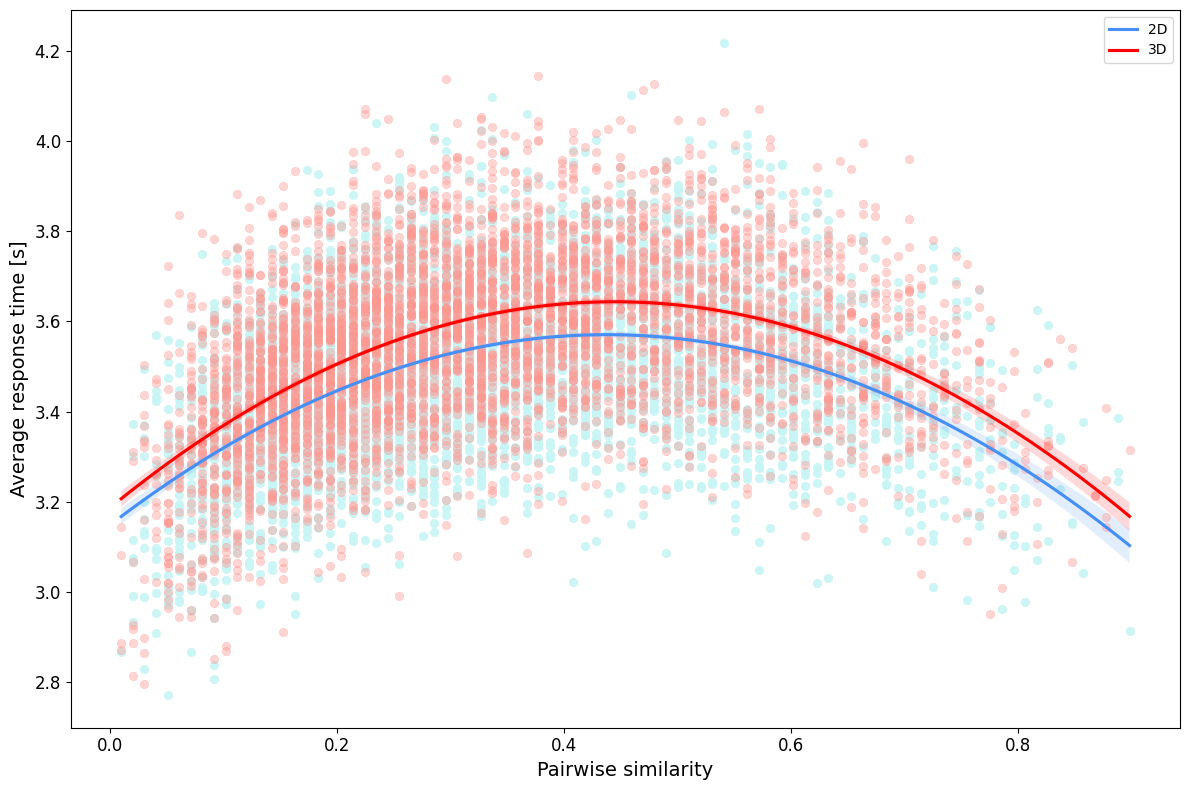

In [11]:
# Compute aggregated similarity judgments
sim_mat_all_2d = aggregate_judgments_in_session(session="2D", pilot=False, verbose=False)
sim_mat_all_3d = aggregate_judgments_in_session(session="3D", pilot=False, verbose=False)
# vectorize_similarity_matrix(sim_mat_all_2d)  # noqa: ERA001
# vectorize_similarity_matrix(sim_mat_all_3d)  # noqa: ERA001
sim_mat_all_dict = {"2D": sim_mat_all_2d, "3D": sim_mat_all_3d}

# Show relationship between similarity and response times
sim_rt_dfs = {}  # init
fig, ax = plt.subplots(nrows=1, ncols=1, num="similarity ~ response times", figsize=(12, 8))
add_mean_lines = False
for session, tr_table in tr_tables.items():
    path_to_sim_rt_tab = Path(paths.results.main.rt, f"{session}_similarity-rt.csv")
    if path_to_sim_rt_tab.is_file():
        sim_rt_df = pd.read_csv(path_to_sim_rt_tab, index_col=0)
    else:
        sim_rt_df = pd.DataFrame(columns=["similarity", "response_time"])
        ctn_nan = 0
        for i, (a, b) in tqdm(  # noqa: B007 (a: face_j, b: face_k): (0, 1), (0, 2) ... (98, 99)
            enumerate(combinations(range(params.main.n_faces), r=2)),
            total=len(vectorize_similarity_matrix(sim_mat_all_2d)),  # 4950
        ):
            # Get behaviroal similarity of face a & b: S(a, b)
            sim_a_b = sim_mat_all_dict[session][a, b]

            # Get tripled IDs (in [1,100]) which contain a and b
            a_b_triplet = [t for t in tr_table.triplet if str(a + 1) in t.split("_") and str(b + 1) in t.split("_")]

            m_rt = tr_table.loc[tr_table.triplet.isin(a_b_triplet)].response_time.dropna().mean()
            if pd.isna(m_rt):
                ctn_nan += 1
                continue

            sim_rt_df = sim_rt_df.append({"similarity": sim_a_b, "response_time": m_rt}, ignore_index=True)

        # Save sim_rt_df
        sim_rt_df.index = (str(comb) for comb in list(combinations(range(params.main.n_faces), r=2)))
        path_to_sim_rt_tab.parent.mkdir(parents=True, exist_ok=True)
        sim_rt_df.to_csv(path_to_sim_rt_tab)

    sim_rt_dfs[session] = sim_rt_df
    # TODO: this does not match poly-1 fit below  # noqa: FIX002
    print("pearsonr(sim ~ RT) (order=1):", pearsonr(sim_rt_df.similarity, sim_rt_df.response_time))
    # Correlation with 2nd order polynomial
    # TODO: check: visually the poly-order=2 R should be higher than order=1.  # noqa: FIX002
    print("pearsonr(sim ~ RT) (order=2):", pearsonr(sim_rt_df.similarity, sim_rt_df.response_time**2))

    # sns.regplot(data=sim_rt_df, x="similarity", y="response_time", order=1, line_kws={"color": "red"})  # noqa: ERA001, E501
    sns.regplot(
        data=sim_rt_df,
        x="similarity",
        y="response_time",
        order=2,
        line_kws={"color": session_lines[session], "label": session},
        scatter_kws={
            "alpha": {"2D": 0.9, "3D": 0.4}[session],
            "color": session_colors[session],
            "linewidths": 0.5,
        },  # "s": 12,
        ax=ax,
        # label=session,  # noqa: ERA001
    )
    if add_mean_lines:
        plt.hlines(
            y=sim_rt_df.response_time.mean(),
            xmin=0,
            xmax=sim_rt_df.similarity.max(),
            colors={"2D": "blue", "3D": "red"}[session],
            linestyles="dashed",
        )
plt.xlabel(xlabel="Pairwise similarity", fontsize=14)
plt.ylabel(ylabel="Average response time [s]", fontsize=14)
# increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.tight_layout()
for fmt in ["png", "pdf"]:
    plt.savefig(Path(paths.results.main.rt, f"pairwise-similarity_rt.{fmt}"), dpi=300)

# Use Polyfit + sm.OLS for model summary
for session, sim_rt_df in sim_rt_dfs.items():
    print(session)
    # Plot to verify
    # TODO: dump plotting in function  # noqa: FIX002
    # plt.figure(f"Fit different poly's for session {session}") # noqa: ERA001
    # plt.scatter(sim_rt_df["similarity"], sim_rt_df["response_time"], alpha=0.5) # noqa: ERA001
    for degree in range(1, 2 + 1):
        polynomial_features = PolynomialFeatures(degree=degree)
        xp = polynomial_features.fit_transform(sim_rt_df[["similarity"]].to_numpy())
        model = sm.OLS(sim_rt_df[["response_time"]], xp).fit()
        ypred = model.predict(xp)
        print(model.summary())

        summary_message = f"\n({session}-session: {degree}-order polynomial fit: R2={model.rsquared:.3f}; "
        for bi, b in enumerate(model.params):
            summary_message += f"b{bi}={b:.3f}, SE{bi}={model.bse[bi]:.3f}, "
            summary_message += f"t{bi}={model.tvalues[bi]:.3f}, p{bi}<{model.pvalues[bi]:.3f}; "
        summary_message += f"AIC={model.aic:.0f}, BIC={model.bic:.0f}).\n"
        print(summary_message)
        # plt.plot(sim_rt_df["similarity"].to_numpy(), ypred, "*", label=f"poly={degree}")  # , color="red") # noqa: ERA001, E501
    # plt.xlabel("similarity") # noqa: ERA001
    # plt.ylabel("Response times [s]") # noqa: ERA001
    # plt.legend() # noqa: ERA001

## Predicting human similarity judgments

### Across all samples

#### Maximal empirical accuracy (noise ceiling)
Maximal empirical accuracy is the upper bound for model performance based on the human choice variance 
within the same face triplets (often called the noise ceiling).

In the following we report the accuracy adjusted for the maximal empirical accuracy, followed by the 
bare accuracy in brackets.

In [12]:
mea_sess_tab = pd.read_csv(paths.results.main.noise_ceiling.accuracy_table, index_col="session").loc[["2D", "3D"]]
mea_sess_tab

sample_type  max_acc  min_n_samples
session                                                 
2D              multi-sub-sample   0.6634            5.0
2D       multi-sub-sample_female   0.6483            5.0
2D         multi-sub-sample_male   0.6433            5.0
3D              multi-sub-sample   0.6867            5.0
3D       multi-sub-sample_female   0.6767            5.0
3D         multi-sub-sample_male   0.7100            5.0

#### Sparse encoding models

##### SPoSE

In [13]:
for session in params.SESSIONS:
    cprint(f"\n{session} Session:", fm="ul")
    spose_sess_acc = list_spose_model_performances(session=session).iloc[0].val_acc
    mea_sess = mea_sess_tab[mea_sess_tab.sample_type == "multi-sub-sample"].loc[session].max_acc
    cprint(
        string=f"\nAccuracy of best performing SPoSE model {session}: "
        f"{spose_sess_acc / mea_sess:.2%} ({spose_sess_acc:.2%})",
        col="g",
    )


2D Session:

Accuracy of best performing SPoSE model 2D: 89.32% (59.26%)

3D Session:

Accuracy of best performing SPoSE model 3D: 86.01% (59.06%)


##### VICE

In [14]:
for session in params.SESSIONS:
    cprint(f"\n{session} Session:", fm="ul")
    vice_sess_acc = list_vice_model_performances(session=session).iloc[0].val_acc
    mea_sess = mea_sess_tab[mea_sess_tab.sample_type == "multi-sub-sample"].loc[session].max_acc
    cprint(
        string=f"\nAccuracy of best performing VICE model {session}: "
        f"{vice_sess_acc / mea_sess:.2%} ({vice_sess_acc:.2%})",
        col="g",
    )


2D Session:

Accuracy of best performing VICE model 2D: 89.34% (59.27%)

3D Session:

Accuracy of best performing VICE model 3D: 86.32% (59.27%)


#### Deep encoding models
##### VGG-Face FrozenCore
This variant of VGG Face uses the pre-trained VGG-Face weights up until the layer `XX`[FILL]. 
The newly attached upper part of the model consists of further convolutional layers, i.e., the decision block is fully convolutional.

In [15]:
# Read the VGG performance table
hp_tab = get_vgg_performance_table(sort_by_acc=True)

In [16]:
for session in params.SESSIONS:
    cprint(f"\n{session} Session:", fm="ul")
    model_name, test_acc = hp_tab.loc[hp_tab.session == session, ["model_name", "test_acc"]].iloc[0]
    mea_sess = mea_sess_tab[mea_sess_tab.sample_type == "multi-sub-sample"].loc[session].max_acc
    cprint(
        string=f"\nAccuracy of best performing VGGFace model "
        f"'{model_name}' {session}: {test_acc / mea_sess:.2%} ({test_acc:.2%})",
        col="g",
    )


2D Session:

Accuracy of best performing VGGFace model '2023-11-15_04-44_VGGFaceHumanjudgmentFrozenCore' 2D: 85.92% (57.00%)

3D Session:

Accuracy of best performing VGGFace model '2023-12-11_19-46_VGGFaceHumanjudgmentFrozenCore' 3D: 84.17% (57.80%)


##### VGG-Face Multi-view pretraining
###### TODO: is still in the making

In [17]:
pass

#### Predicting one viewing condition from the other
##### Extract maximal emperical accuracy across viewing conditions (in the multi-sub-sample).

In [18]:
mea_tab_both = pd.read_csv(paths.results.main.noise_ceiling.accuracy_table, index_col="session").loc["both"]
mea_acc_both = mea_tab_both.loc[mea_tab_both.sample_type == "multi-sub-sample"].max_acc.item()
cprint(f"Maximal emperical accuracy across viewing conditions is: {mea_acc_both:.2%}.", col="g")

Maximal emperical accuracy across viewing conditions is: 66.05%.


Now we take the same computation but across viewing conditions of the full-sample (i.e., data from the main study).

In [19]:
cross_sess_acc = mea_tab_both.loc[mea_tab_both.sample_type == "full-sample"].max_acc.item()
adjusted_cross_sess_acc = cross_sess_acc / mea_acc_both
cprint(
    string=f"\nPredicting human choices in one viewing condition with the choices in the other condition\n"
    f"leads to an accuracy of {adjusted_cross_sess_acc:.2%} ({cross_sess_acc:.2%}).\n",
    col="g",
    fm="bo",
)


Predicting human choices in one viewing condition with the choices in the other condition
leads to an accuracy of 72.76% (48.06%).



#### Accuracy when gender matches

Calculate the probabilty when participants would only choose the odd-one-out based on gender. This would be a theoretical upper bound for an accuracy based on such a simply choice-behavior.
That is, when there is a triplet with, e.g., `M`-`M`-`F`, they choose `F`. For triplets with one gender only, they guess randomly.

In [20]:
comb_tab = create_all_triple_combinations(n_faces=params.main.n_faces)

# Only one gender triplets
n_female_comb_tab = len(comb_tab[comb_tab.le(50).all(axis=1)])
n_male_comb_tab = len(comb_tab[comb_tab.ge(51).all(axis=1)])
# Same as: len(create_all_triple_combinations(n_faces=params.main.n_faces // 2))

n_mixed_comb_tab = len(comb_tab) - n_female_comb_tab - n_male_comb_tab

In [21]:
# Very conservative
p_only_mixed_trials_correct = n_mixed_comb_tab / len(comb_tab)
print(
    f"The theoretical highest accuracy when predicting only mixed gender trials correctly,\n\t"
    f"would be at: {p_only_mixed_trials_correct:.2%}"
)

# With chance level for gender only trials (less conservative)
p_mixed_trials_correct_and_chance_in_one_gender_trials = (
    n_mixed_comb_tab + (1 / 3 * (n_female_comb_tab + n_male_comb_tab))
) / len(comb_tab)
print(
    "\nThe theoretical highest accuracy when predicting mixed gender trials correctly and "
    "one-gender trials on chance level, "
    f"\n\twould be at: {p_mixed_trials_correct_and_chance_in_one_gender_trials:.2%}"
)

The theoretical highest accuracy when predicting only mixed gender trials correctly,
	would be at: 75.76%

The theoretical highest accuracy when predicting mixed gender trials correctly and one-gender trials on chance level, 
	would be at: 83.84%


For now, this is just of theoretical interest, and might be reported in the appendix of the main paper.

### Predictions within gender trials

#### Maximial empirical accuracy within gender-exclusive-trials

In [22]:
mea_sess_gender_tab = pd.read_csv(paths.results.main.noise_ceiling.accuracy_table, index_col="session").loc[
    ["2D", "3D"]
]
mea_sess_gender_tab = mea_sess_gender_tab[
    mea_sess_gender_tab.sample_type.str.contains("male")
    & mea_sess_gender_tab.sample_type.str.contains("multi-sub-sample")
]
mea_sess_gender_tab

sample_type  max_acc  min_n_samples
session                                                 
2D       multi-sub-sample_female   0.6483            5.0
2D         multi-sub-sample_male   0.6433            5.0
3D       multi-sub-sample_female   0.6767            5.0
3D         multi-sub-sample_male   0.7100            5.0

#### Sparse encoding models

##### SPoSE

In [23]:
for session in params.SESSIONS:
    cprint(f"\n{session} Session:", fm="ul")
    for gender in params.GENDERS:
        cprint(f"\t{gender}:", fm="ul")
        spose_sess_acc_gender = list_spose_model_performances(session=session, gender=gender).iloc[0].val_acc

        mea_sess_gender = mea_sess_gender_tab[mea_sess_gender_tab.sample_type.str.contains(f"_{gender}")].loc[
            session, "max_acc"
        ]

        cprint(
            string=f"\nAccuracy of best performing SPoSE model {session} within exclusive '{gender}' trials: "
            f"{spose_sess_acc_gender / mea_sess_gender:.2%} ({spose_sess_acc_gender:.2%})",
            col="g" if gender == "female" else "b",
            fm="bo",
        )


2D Session:
	female:

Accuracy of best performing SPoSE model 2D within exclusive 'female' trials: 87.75% (56.89%)
	male:

Accuracy of best performing SPoSE model 2D within exclusive 'male' trials: 90.88% (58.46%)

3D Session:
	female:

Accuracy of best performing SPoSE model 3D within exclusive 'female' trials: 85.43% (57.81%)
	male:

Accuracy of best performing SPoSE model 3D within exclusive 'male' trials: 81.30% (57.72%)


##### VICE

In [24]:
for session in params.SESSIONS:
    cprint(f"\n{session} Session:", fm="ul")
    for gender in params.GENDERS:
        cprint(f"\t{gender}:", fm="ul")
        vice_sess_acc_gender = list_vice_model_performances(session=session, gender=gender).iloc[0].val_acc

        mea_sess_gender = mea_sess_gender_tab[mea_sess_gender_tab.sample_type.str.contains(f"_{gender}")].loc[
            session, "max_acc"
        ]

        cprint(
            string=f"\nAccuracy of best performing VICE model {session} within exclusive '{gender}' trials: "
            f"{vice_sess_acc_gender / mea_sess_gender:.2%} ({vice_sess_acc_gender:.2%})",
            col="g" if gender == "female" else "b",
            fm="bo",
        )


2D Session:
	female:

Accuracy of best performing VICE model 2D within exclusive 'female' trials: 87.52% (56.74%)
	male:

Accuracy of best performing VICE model 2D within exclusive 'male' trials: 89.80% (57.77%)

3D Session:
	female:

Accuracy of best performing VICE model 3D within exclusive 'female' trials: 86.01% (58.20%)
	male:

Accuracy of best performing VICE model 3D within exclusive 'male' trials: 81.59% (57.93%)


#### Deep encoding models
##### VGG-Face FrozenCore

In [25]:
for session in params.SESSIONS:
    cprint(f"\n{session} Session:", fm="ul")
    for gender in params.GENDERS:
        cprint(f"\t{gender}:", fm="ul")

        # Read the VGG performance table
        hp_tab_gender = get_vgg_performance_table(sort_by_acc=True, exclusive_gender_trials=gender)

        model_name, test_acc = hp_tab_gender.loc[hp_tab_gender.session == session, ["model_name", "test_acc"]].iloc[0]

        mea_sess_gender = mea_sess_gender_tab[mea_sess_gender_tab.sample_type.str.contains(f"_{gender}")].loc[
            session, "max_acc"
        ]

        cprint(
            string=f"\nAccuracy of best performing VGGFace model '{model_name}' {session} "
            f"within exclusive '{gender}' trials: "
            f"{test_acc / mea_sess_gender:.2%} ({test_acc:.2%})",
            col="g" if gender == "female" else "b",
            fm="bo",
        )


2D Session:
	female:

Accuracy of best performing VGGFace model '2023-11-24_14-57_VGGFaceHumanjudgmentFrozenCore' 2D within exclusive 'female' trials: 82.52% (53.50%)
	male:

Accuracy of best performing VGGFace model '2023-11-26_09-05_VGGFaceHumanjudgmentFrozenCore' 2D within exclusive 'male' trials: 85.34% (54.90%)

3D Session:
	female:

Accuracy of best performing VGGFace model '2023-11-25_10-17_VGGFaceHumanjudgmentFrozenCore' 3D within exclusive 'female' trials: 79.21% (53.60%)
	male:

Accuracy of best performing VGGFace model '2023-11-26_22-57_VGGFaceHumanjudgmentFrozenCore' 3D within exclusive 'male' trials: 78.45% (55.70%)


##### VGG-Face Multi-view pretraining
###### TODO: is still in the making

In [26]:
pass

## Representational differences between viewing conditions (2D & 3D)

*Differences between the static 2D and the dynamic 3D condition*

### Correlations of similarity matrices (RSA)
###### TODO: add info about maximal empirical correlation coefficient.

In [27]:
rsa_corr_df = get_corr_df_rsm(corr_name=CORR_NAME, metric=METRIC)
# get_mer_table() # noqa: ERA001

In [28]:
# Set N highest correlating VGG layers
n_highest_vgg: int = 5


2D_BSM

Spearman correlation 2D_BSM ~ 3D_BSM_r: r=0.933, p<=0

Spearman correlation 2D_BSM ~ CFD_PFF_r: r=0.258, p<=5.2e-76

Spearman correlation 2D_BSM ~ DECA_SHAPE_r: r=0.259, p<=1e-76

Spearman correlation 2D_BSM ~ DECA_EXP_r: r=0.305, p<=2.3e-107

Spearman correlation 2D_BSM ~ DECA_POSE_r: r=0.089, p<=3.1e-10

Spearman correlation 2D_BSM ~ DECA_CAM_r: r=0.030, p<=0.038

Spearman correlation 2D_BSM ~ DECA_TEX_r: r=0.468, p<=2.2e-267

Spearman correlation 2D_BSM ~ DECA_DETAIL_r: r=0.319, p<=1.9e-117

Spearman correlation 2D_BSM ~ SPoSE_2D_r: r=0.927, p<=0

Spearman correlation 2D_BSM ~ VICE_2D_r: r=0.935, p<=0

Spearman correlation 2D_BSM ~ SPoSE_3D_r: r=0.914, p<=0

Spearman correlation 2D_BSM ~ VICE_3D_r: r=0.916, p<=0

Spearman correlation 2D_BSM ~ 2023-11-15_04-44_VGGFaceHumanjudgmentFrozenCore_2D_embedding_r: r=0.776, p<=0

Spearman correlation 2D_BSM ~ 2023-11-15_04-44_VGGFaceHumanjudgmentFrozenCore_2D_decision_r: r=0.876, p<=0



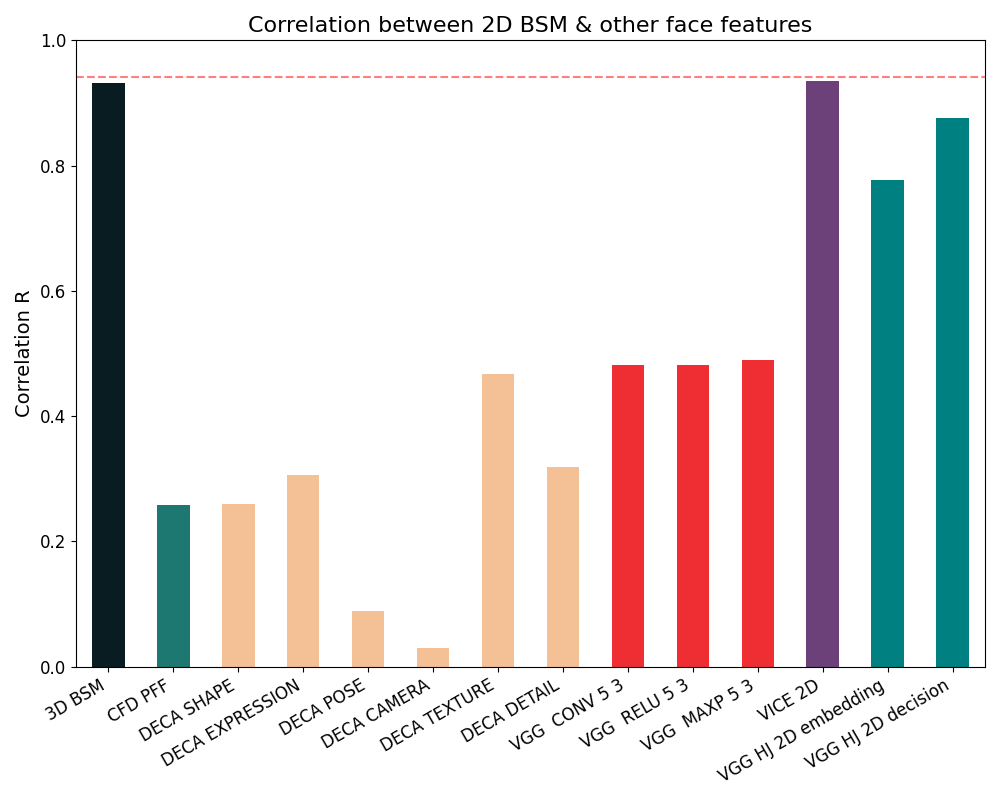


Correlation VGG layers

Spearman correlation 2D_BSM ~ VGG_3D-recon_MAXP_5_3_r: r=0.489, p<=4.8e-296

Spearman correlation 2D_BSM ~ VGG_3D-recon_RELU_5_3_r: r=0.482, p<=2.4e-286

Spearman correlation 2D_BSM ~ VGG_3D-recon_CONV_5_3_r: r=0.482, p<=2.4e-286

Spearman correlation 2D_BSM ~ VGG_3D-recon_FC6_r: r=0.432, p<=1.8e-224

Spearman correlation 2D_BSM ~ VGG_3D-recon_FC6-DROPOUT_r: r=0.432, p<=1.8e-224



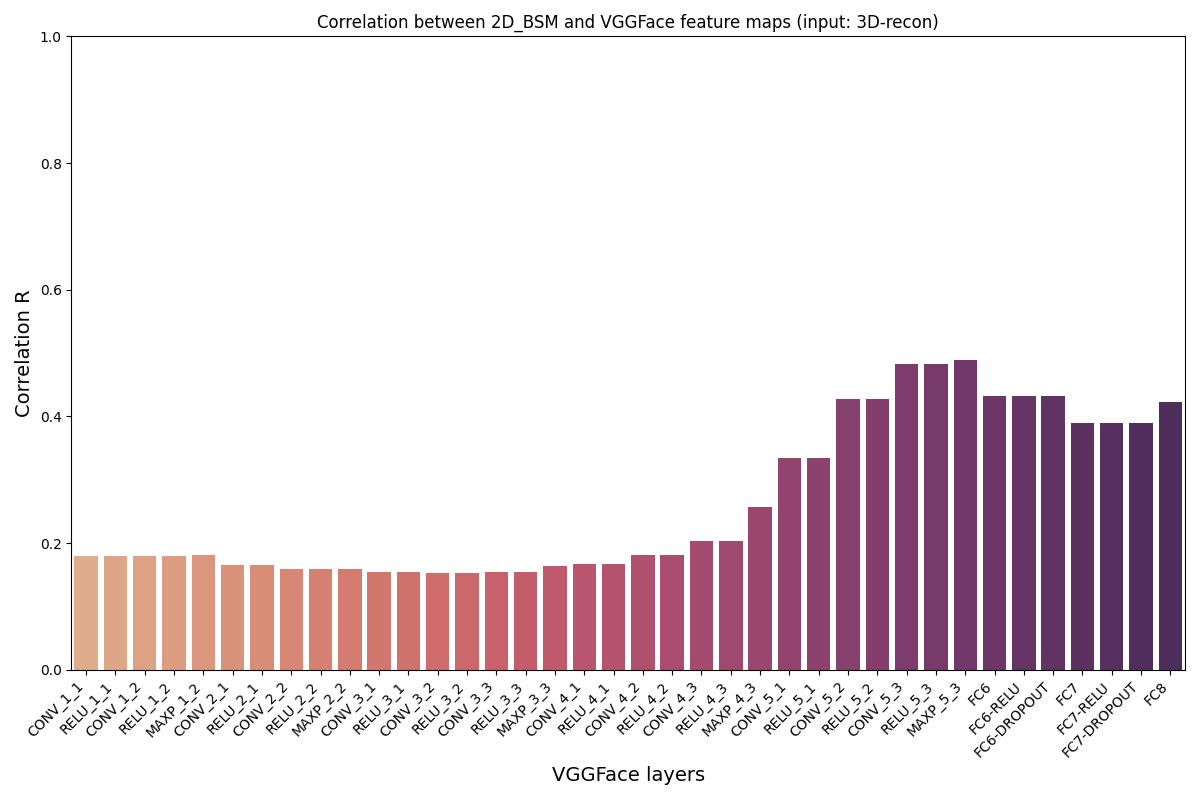


********************************************************************************

3D_BSM

Spearman correlation 3D_BSM ~ 2D_BSM_r: r=0.933, p<=0

Spearman correlation 3D_BSM ~ CFD_PFF_r: r=0.246, p<=2.2e-69

Spearman correlation 3D_BSM ~ DECA_SHAPE_r: r=0.249, p<=4.7e-71

Spearman correlation 3D_BSM ~ DECA_EXP_r: r=0.299, p<=5.9e-103

Spearman correlation 3D_BSM ~ DECA_POSE_r: r=0.093, p<=6.9e-11

Spearman correlation 3D_BSM ~ DECA_CAM_r: r=0.041, p<=0.0042

Spearman correlation 3D_BSM ~ DECA_TEX_r: r=0.478, p<=4.8e-281

Spearman correlation 3D_BSM ~ DECA_DETAIL_r: r=0.326, p<=1.4e-122

Spearman correlation 3D_BSM ~ SPoSE_2D_r: r=0.912, p<=0

Spearman correlation 3D_BSM ~ VICE_2D_r: r=0.916, p<=0

Spearman correlation 3D_BSM ~ SPoSE_3D_r: r=0.936, p<=0

Spearman correlation 3D_BSM ~ VICE_3D_r: r=0.939, p<=0

Spearman correlation 3D_BSM ~ 2023-12-11_19-46_VGGFaceHumanjudgmentFrozenCore_3D_embedding_r: r=0.721, p<=0

Spearman correlation 3D_BSM ~ 2023-12-11_19-46_VGGFaceHumanjudgmentFroz

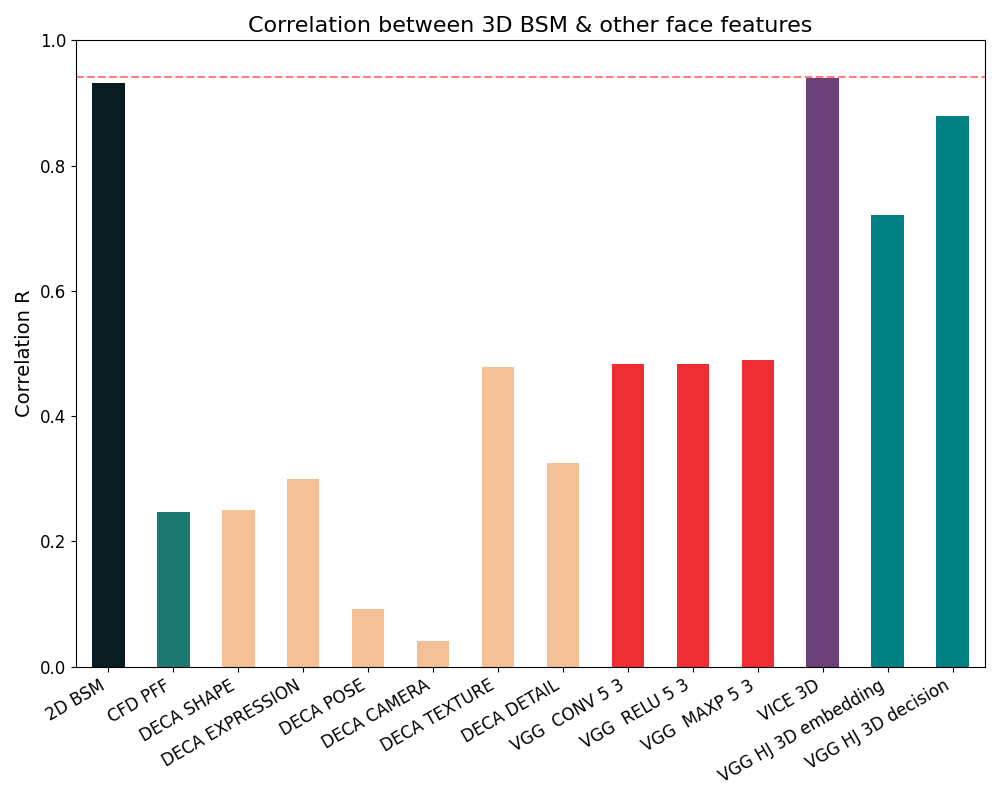


Correlation VGG layers

Spearman correlation 3D_BSM ~ VGG_3D-recon_MAXP_5_3_r: r=0.490, p<=5.4e-297

Spearman correlation 3D_BSM ~ VGG_3D-recon_RELU_5_3_r: r=0.483, p<=3e-287

Spearman correlation 3D_BSM ~ VGG_3D-recon_CONV_5_3_r: r=0.483, p<=3e-287

Spearman correlation 3D_BSM ~ VGG_3D-recon_FC6_r: r=0.435, p<=4.8e-228

Spearman correlation 3D_BSM ~ VGG_3D-recon_FC6-DROPOUT_r: r=0.435, p<=4.8e-228



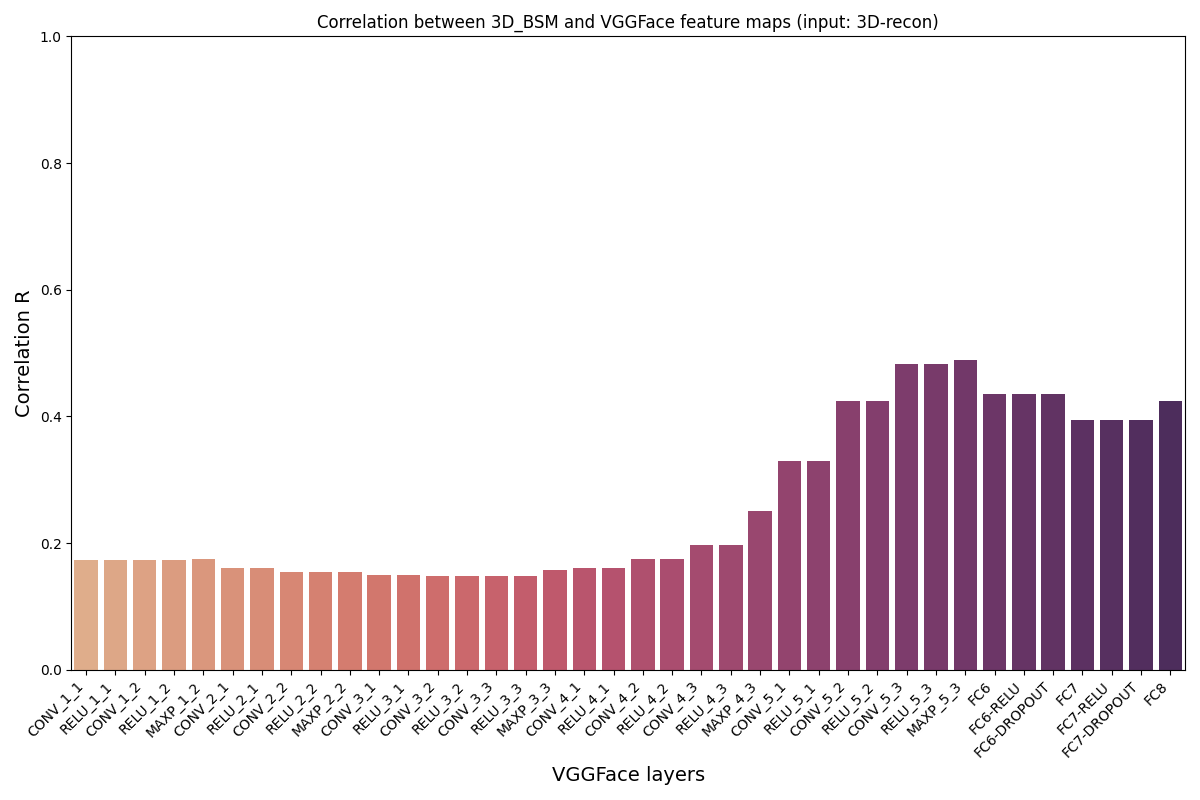


********************************************************************************


In [29]:
# All triplets
for sess in params.SESSIONS:
    bsm_name = f"{sess}_BSM"
    cprint(f"\n{bsm_name}\n", col="b", fm="ul")

    # Filter columns/correlations of interest
    cois = rsa_corr_df.loc[bsm_name].dropna().index
    cois = [c for c in cois if "VGG_" not in c and "PCA" not in c]
    cois = [c for c in cois if ("VGGFaceHumanjudgment" not in c) or ("VGGFaceHumanjudgment" and sess in c)]
    cois = [c for c in cois if "_r" in c]

    for coi in cois:
        r, p = rsa_corr_df.loc[bsm_name, [f"{coi}", f"{coi.replace('_r', '_p')}"]]
        print(f"{CORR_NAME} correlation {bsm_name} ~ {coi}: r={r:.3f}, p<={p:.2g}\n")

    other_bsm = bsm_name.replace(sess, [s for s in params.SESSIONS if s != sess].pop())
    ext = ".png"
    corr_fig_path = Path(paths.results.main.rsa, f"{CORR_NAME}_{bsm_name}-FaceFeats_{METRIC}").with_suffix(ext)
    img = Image(corr_fig_path, width=800)
    dspl(img)

    cprint("\nCorrelation VGG layers\n", fm="ul")

    vgg_cois = rsa_corr_df.loc[bsm_name].dropna().index
    vgg_cois = [c for c in vgg_cois if "VGG_" in c and "PCA" not in c and "org_" not in c]
    vgg_cois = rsa_corr_df.loc[bsm_name, vgg_cois].sort_values(ascending=False)[:n_highest_vgg].index

    for coi in vgg_cois:
        r, p = rsa_corr_df.loc[bsm_name, [f"{coi}", f"{coi.replace('_r', '_p')}"]]
        print(f"{CORR_NAME} correlation {bsm_name} ~ {coi}: r={r:.3f}, p<={p:.2g}\n")

    vgg_corr_fig_path = Path(
        paths.results.main.rsa,
        f"VGG_3D-recon_feat-{METRIC}-sim_{bsm_name}_{CORR_NAME.lower()}_corr",
    ).with_suffix(ext)

    img = Image(vgg_corr_fig_path, width=800)
    dspl(img)

    cprint("\n" + "*" * 80, col="b")

### Correlations within exclusive gender trials (RSA)


2D_BSM_female_only

Spearman correlation 2D_BSM_female_only ~ 3D_BSM_female_only_r: r=0.839, p<=0

Spearman correlation 2D_BSM_female_only ~ 3D_BSM_male_only_r: r=0.036, p<=0.21

Spearman correlation 2D_BSM_female_only ~ 2D_BSM_male_only_r: r=0.046, p<=0.11

Spearman correlation 2D_BSM_female_only ~ CFD_PFF_female_only_r: r=0.216, p<=2e-14

Spearman correlation 2D_BSM_female_only ~ DECA_SHAPE_female_only_r: r=0.155, p<=4.8e-08

Spearman correlation 2D_BSM_female_only ~ DECA_EXP_female_only_r: r=0.150, p<=1.3e-07

Spearman correlation 2D_BSM_female_only ~ DECA_POSE_female_only_r: r=0.109, p<=0.00013

Spearman correlation 2D_BSM_female_only ~ DECA_CAM_female_only_r: r=0.095, p<=0.00085

Spearman correlation 2D_BSM_female_only ~ DECA_TEX_female_only_r: r=0.154, p<=5.6e-08

Spearman correlation 2D_BSM_female_only ~ DECA_DETAIL_female_only_r: r=0.064, p<=0.024

Spearman correlation 2D_BSM_female_only ~ SPoSE_2D_female_only_r: r=0.923, p<=0

Spearman correlation 2D_BSM_female_only ~ VICE_2D

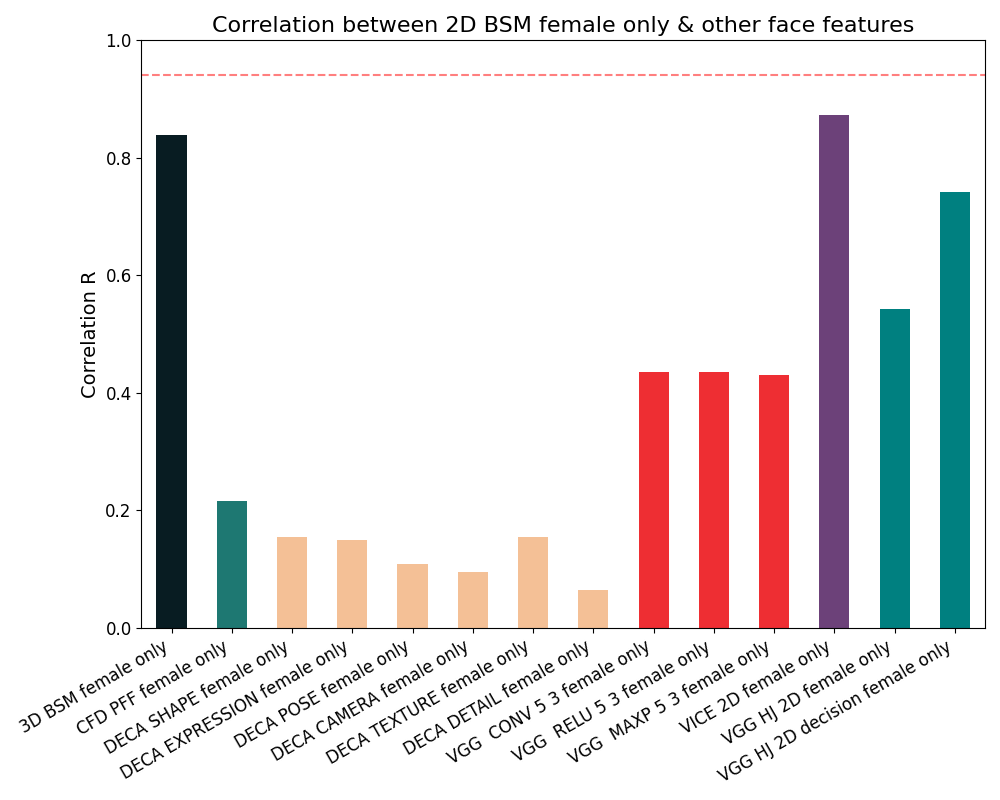


Correlation VGG layers

Spearman correlation 2D_BSM_female_only ~ VGG_3D-recon_RELU_5_3_female_only_r: r=0.436, p<=6.3e-58

Spearman correlation 2D_BSM_female_only ~ VGG_3D-recon_CONV_5_3_female_only_r: r=0.436, p<=6.3e-58

Spearman correlation 2D_BSM_female_only ~ VGG_3D-recon_MAXP_5_3_female_only_r: r=0.431, p<=1.9e-56

Spearman correlation 2D_BSM_female_only ~ VGG_3D-recon_RELU_5_2_female_only_r: r=0.398, p<=7.4e-48

Spearman correlation 2D_BSM_female_only ~ VGG_3D-recon_CONV_5_2_female_only_r: r=0.398, p<=7.4e-48



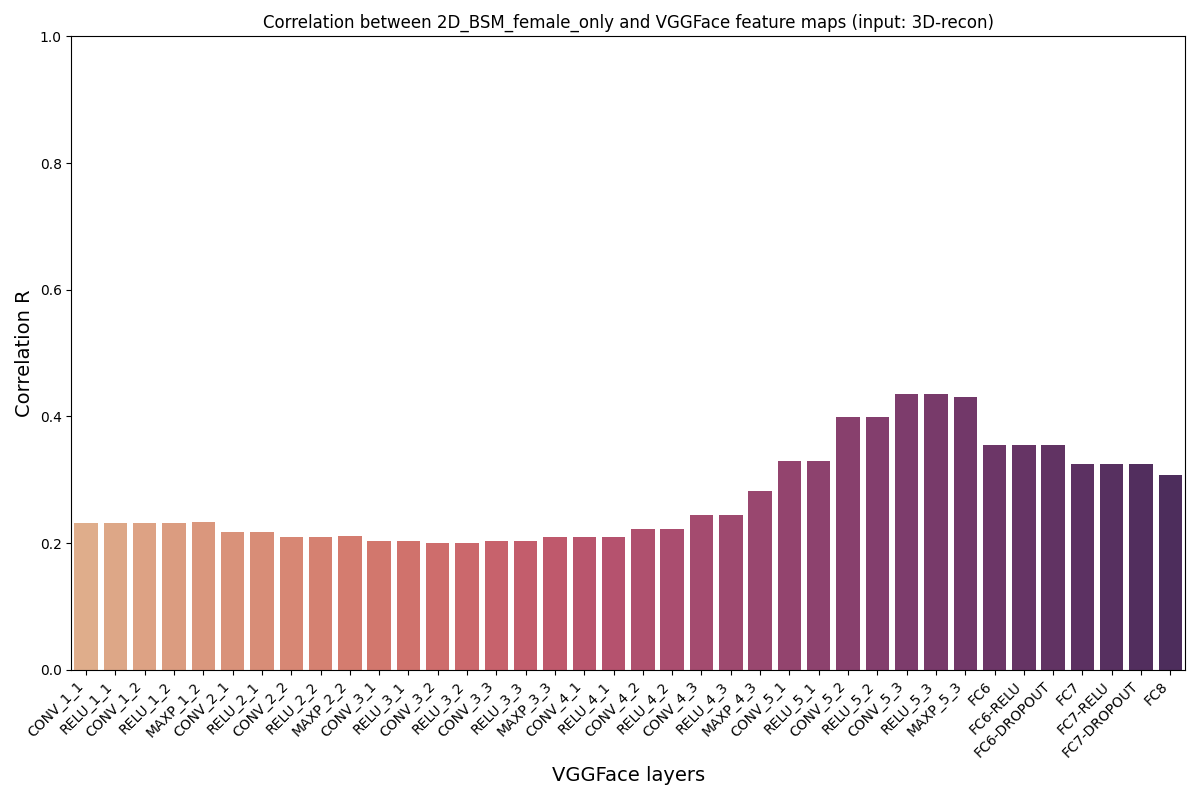


--------------------------------------------------------------------------------

2D_BSM_male_only

Spearman correlation 2D_BSM_male_only ~ 3D_BSM_female_only_r: r=0.055, p<=0.057

Spearman correlation 2D_BSM_male_only ~ 2D_BSM_female_only_r: r=0.046, p<=0.11

Spearman correlation 2D_BSM_male_only ~ 3D_BSM_male_only_r: r=0.881, p<=0

Spearman correlation 2D_BSM_male_only ~ CFD_PFF_male_only_r: r=0.196, p<=5e-12

Spearman correlation 2D_BSM_male_only ~ DECA_SHAPE_male_only_r: r=0.228, p<=5.8e-16

Spearman correlation 2D_BSM_male_only ~ DECA_EXP_male_only_r: r=0.245, p<=3.6e-18

Spearman correlation 2D_BSM_male_only ~ DECA_POSE_male_only_r: r=0.064, p<=0.026

Spearman correlation 2D_BSM_male_only ~ DECA_CAM_male_only_r: r=-0.004, p<=0.9

Spearman correlation 2D_BSM_male_only ~ DECA_TEX_male_only_r: r=0.255, p<=1.2e-19

Spearman correlation 2D_BSM_male_only ~ DECA_DETAIL_male_only_r: r=0.126, p<=1e-05

Spearman correlation 2D_BSM_male_only ~ SPoSE_2D_male_only_r: r=0.917, p<=0

Spearman 

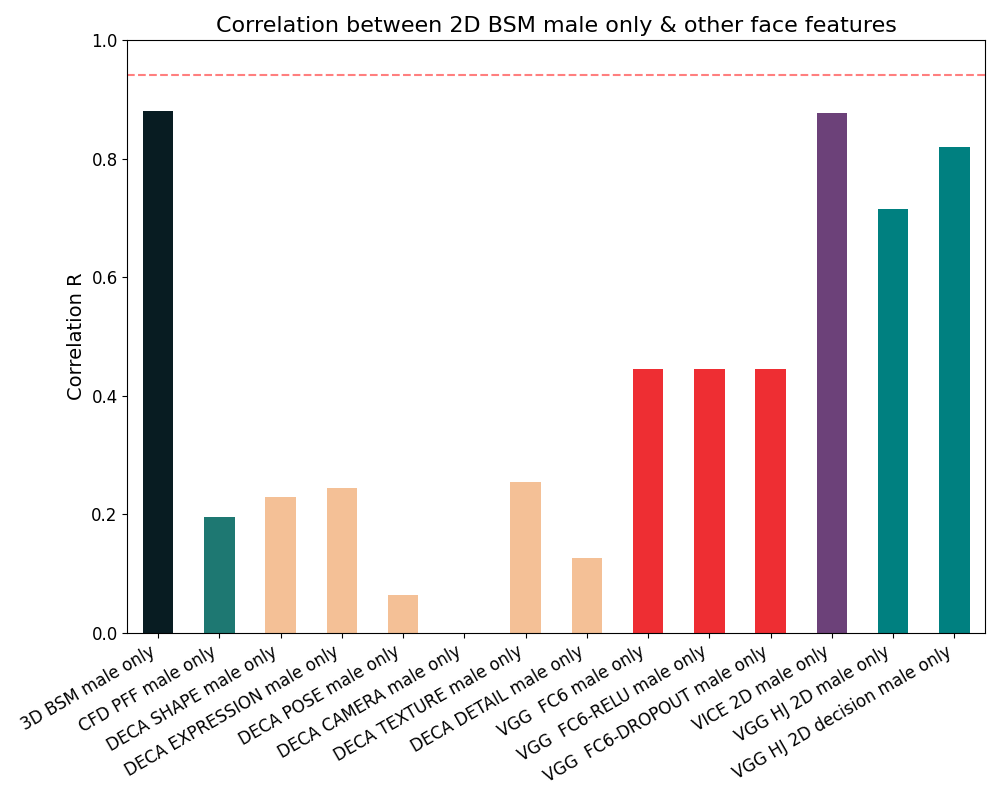


Correlation VGG layers

Spearman correlation 2D_BSM_male_only ~ VGG_3D-recon_FC6-DROPOUT_male_only_r: r=0.445, p<=1.1e-60

Spearman correlation 2D_BSM_male_only ~ VGG_3D-recon_FC6-RELU_male_only_r: r=0.445, p<=1.1e-60

Spearman correlation 2D_BSM_male_only ~ VGG_3D-recon_FC6_male_only_r: r=0.445, p<=1.1e-60

Spearman correlation 2D_BSM_male_only ~ VGG_3D-recon_MAXP_5_3_male_only_r: r=0.441, p<=1.7e-59

Spearman correlation 2D_BSM_male_only ~ VGG_3D-recon_RELU_5_3_male_only_r: r=0.432, p<=9.2e-57



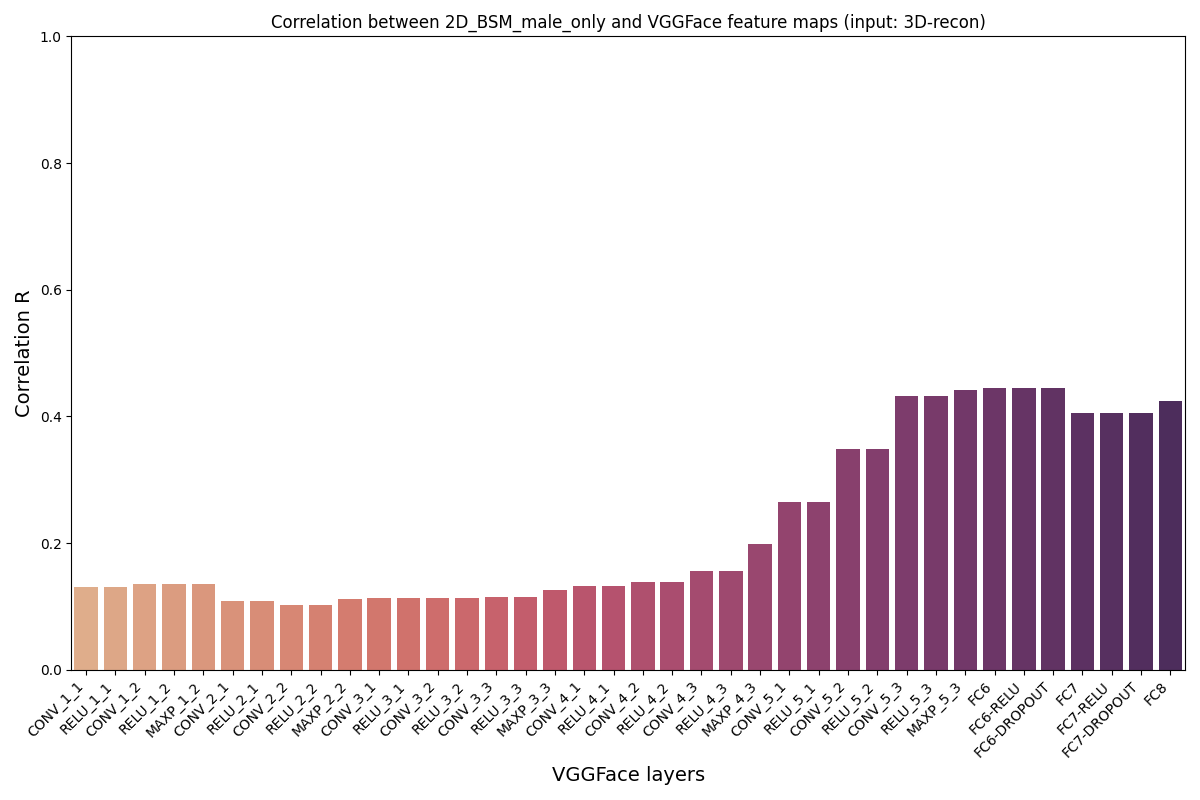


--------------------------------------------------------------------------------

3D_BSM_female_only

Spearman correlation 3D_BSM_female_only ~ 2D_BSM_female_only_r: r=0.839, p<=0

Spearman correlation 3D_BSM_female_only ~ 3D_BSM_male_only_r: r=0.045, p<=0.11

Spearman correlation 3D_BSM_female_only ~ 2D_BSM_male_only_r: r=0.055, p<=0.057

Spearman correlation 3D_BSM_female_only ~ CFD_PFF_female_only_r: r=0.222, p<=4e-15

Spearman correlation 3D_BSM_female_only ~ DECA_SHAPE_female_only_r: r=0.128, p<=7e-06

Spearman correlation 3D_BSM_female_only ~ DECA_EXP_female_only_r: r=0.115, p<=5.9e-05

Spearman correlation 3D_BSM_female_only ~ DECA_POSE_female_only_r: r=0.112, p<=8.4e-05

Spearman correlation 3D_BSM_female_only ~ DECA_CAM_female_only_r: r=0.104, p<=0.00028

Spearman correlation 3D_BSM_female_only ~ DECA_TEX_female_only_r: r=0.169, p<=2.6e-09

Spearman correlation 3D_BSM_female_only ~ DECA_DETAIL_female_only_r: r=0.074, p<=0.01

Spearman correlation 3D_BSM_female_only ~ SPoSE_2D

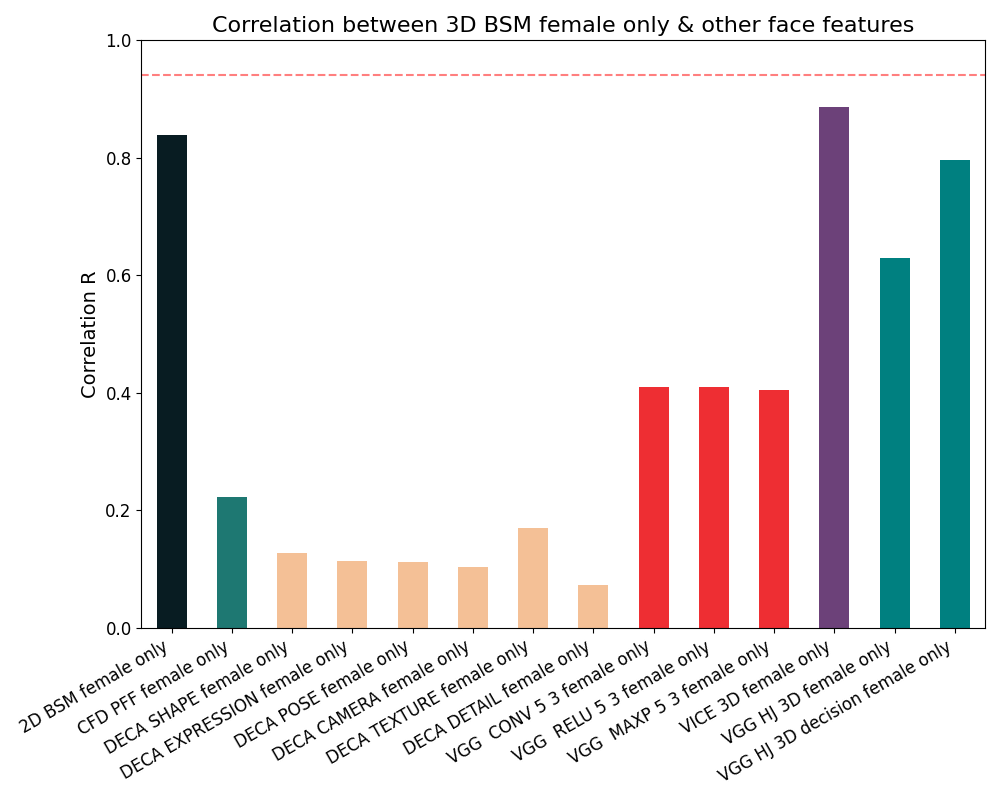


Correlation VGG layers

Spearman correlation 3D_BSM_female_only ~ VGG_3D-recon_RELU_5_3_female_only_r: r=0.410, p<=8e-51

Spearman correlation 3D_BSM_female_only ~ VGG_3D-recon_CONV_5_3_female_only_r: r=0.410, p<=8e-51

Spearman correlation 3D_BSM_female_only ~ VGG_3D-recon_MAXP_5_3_female_only_r: r=0.404, p<=2.1e-49

Spearman correlation 3D_BSM_female_only ~ VGG_3D-recon_RELU_5_2_female_only_r: r=0.377, p<=1.1e-42

Spearman correlation 3D_BSM_female_only ~ VGG_3D-recon_CONV_5_2_female_only_r: r=0.377, p<=1.1e-42



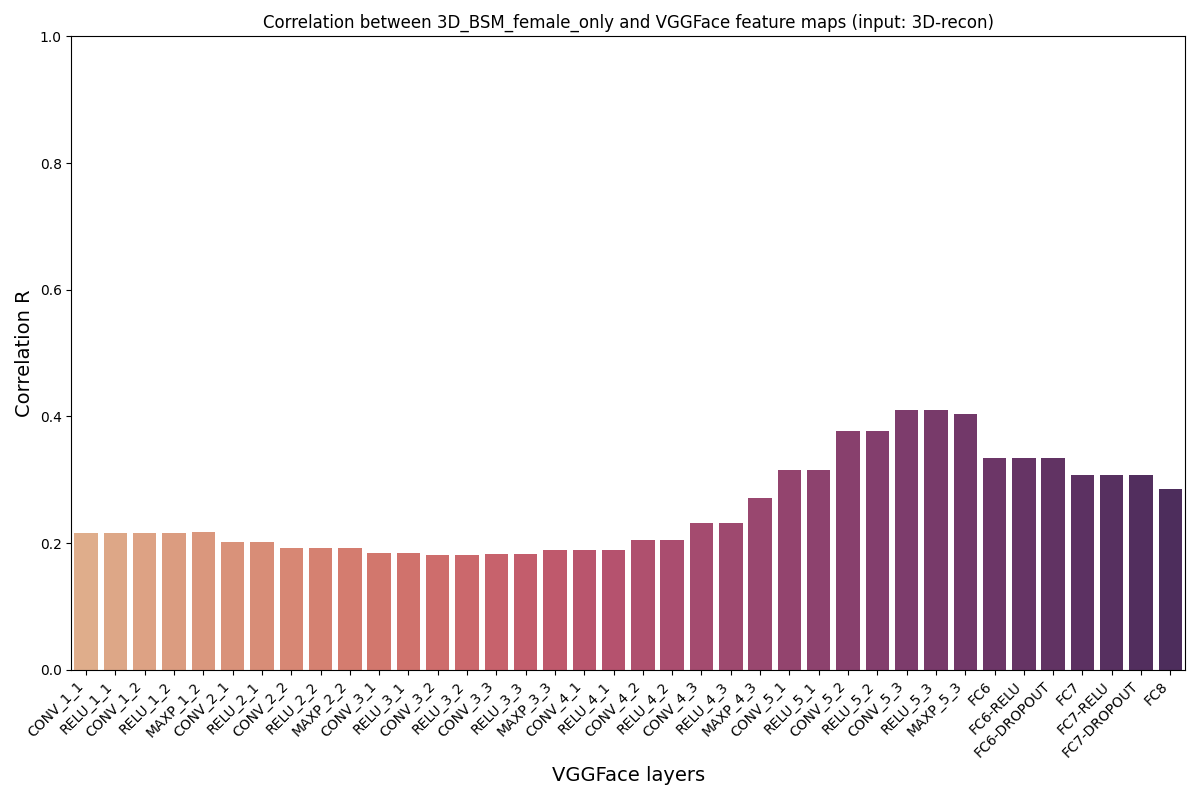


--------------------------------------------------------------------------------

3D_BSM_male_only

Spearman correlation 3D_BSM_male_only ~ 3D_BSM_female_only_r: r=0.045, p<=0.11

Spearman correlation 3D_BSM_male_only ~ 2D_BSM_female_only_r: r=0.036, p<=0.21

Spearman correlation 3D_BSM_male_only ~ 2D_BSM_male_only_r: r=0.881, p<=0

Spearman correlation 3D_BSM_male_only ~ CFD_PFF_male_only_r: r=0.176, p<=5e-10

Spearman correlation 3D_BSM_male_only ~ DECA_SHAPE_male_only_r: r=0.202, p<=9e-13

Spearman correlation 3D_BSM_male_only ~ DECA_EXP_male_only_r: r=0.242, p<=9.1e-18

Spearman correlation 3D_BSM_male_only ~ DECA_POSE_male_only_r: r=0.069, p<=0.016

Spearman correlation 3D_BSM_male_only ~ DECA_CAM_male_only_r: r=0.014, p<=0.63

Spearman correlation 3D_BSM_male_only ~ DECA_TEX_male_only_r: r=0.276, p<=6.4e-23

Spearman correlation 3D_BSM_male_only ~ DECA_DETAIL_male_only_r: r=0.132, p<=3.7e-06

Spearman correlation 3D_BSM_male_only ~ SPoSE_2D_male_only_r: r=0.846, p<=0

Spearman c

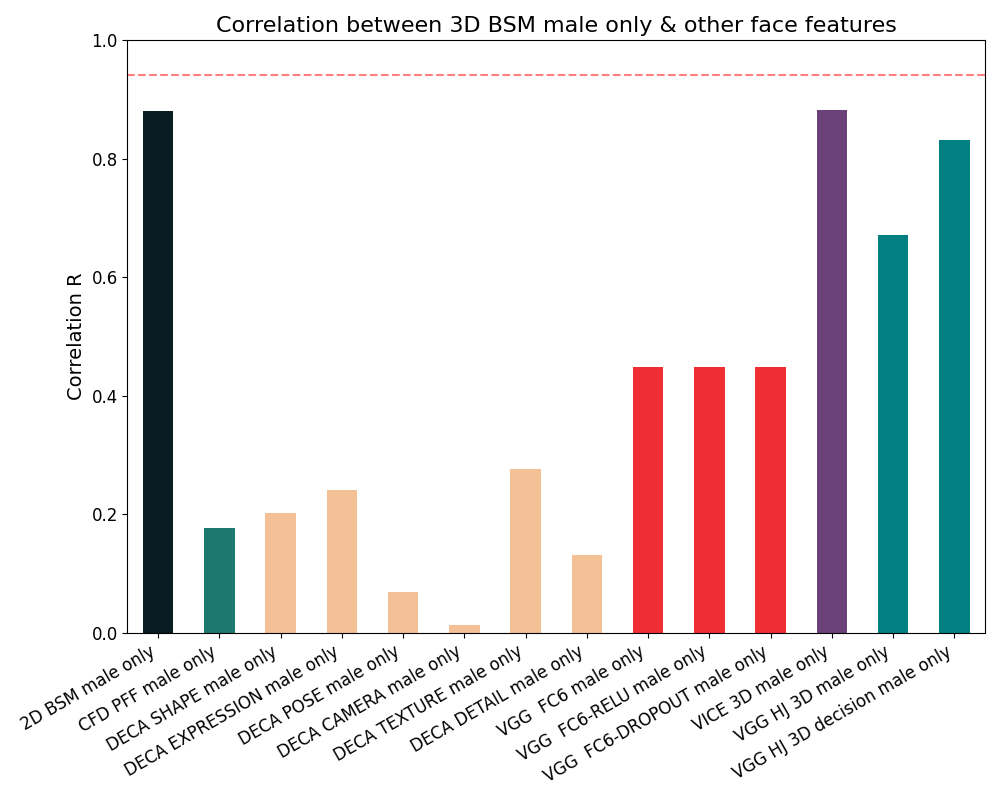


Correlation VGG layers

Spearman correlation 3D_BSM_male_only ~ VGG_3D-recon_FC6_male_only_r: r=0.449, p<=6.9e-62

Spearman correlation 3D_BSM_male_only ~ VGG_3D-recon_FC6-DROPOUT_male_only_r: r=0.449, p<=6.9e-62

Spearman correlation 3D_BSM_male_only ~ VGG_3D-recon_FC6-RELU_male_only_r: r=0.449, p<=6.9e-62

Spearman correlation 3D_BSM_male_only ~ VGG_3D-recon_MAXP_5_3_male_only_r: r=0.441, p<=1.8e-59

Spearman correlation 3D_BSM_male_only ~ VGG_3D-recon_RELU_5_3_male_only_r: r=0.433, p<=3.4e-57



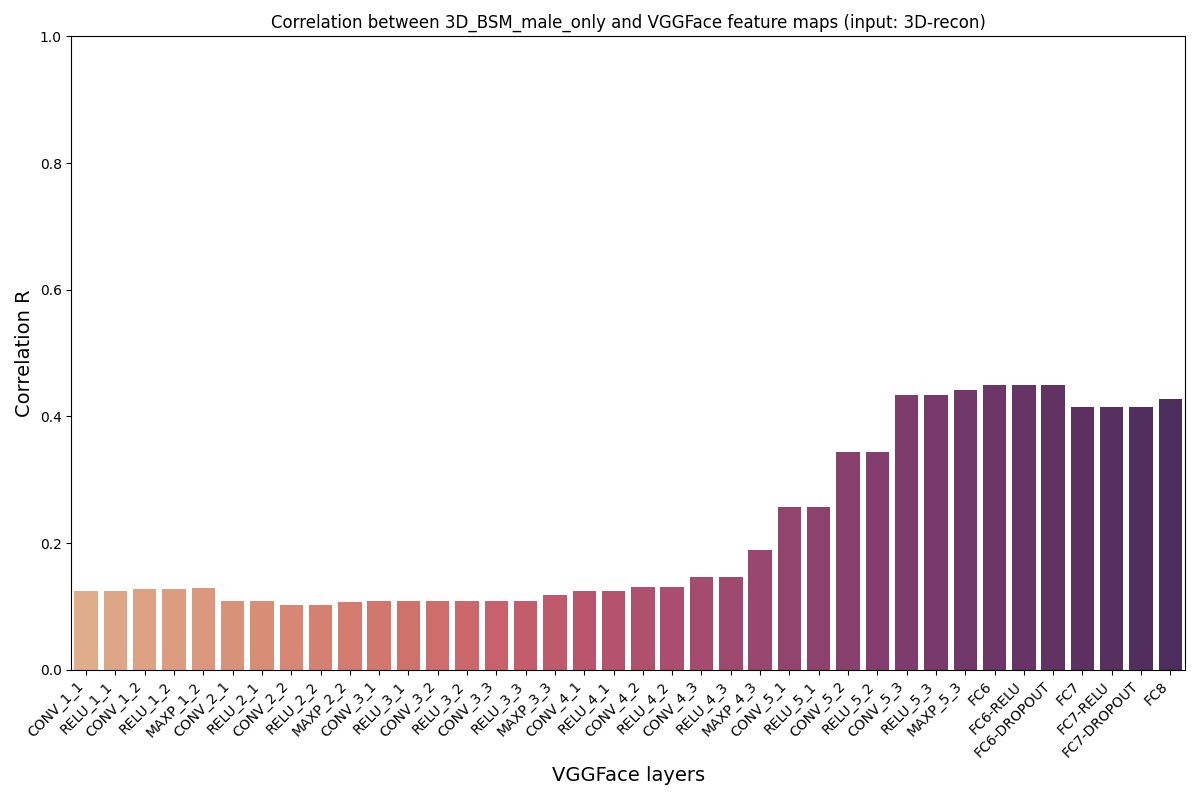


--------------------------------------------------------------------------------


In [30]:
# In exclusive gender triplets
for sess in params.SESSIONS:
    for gender in params.GENDERS:
        bsm_name = f"{sess}_BSM_{gender}_only"
        cprint(f"\n{bsm_name}\n", col="b", fm="ul")

        # Filter columns/correlations of interest
        cois = rsa_corr_df.loc[bsm_name].dropna().index
        cois = [c for c in cois if "VGG_" not in c and "PCA" not in c]
        cois = [c for c in cois if ("VGGFaceHumanjudgment" not in c) or ("VGGFaceHumanjudgment" and sess in c)]
        cois = [c for c in cois if "_r" in c]

        for coi in cois:
            r, p = rsa_corr_df.loc[bsm_name, [f"{coi}", f"{coi.replace('_r', '_p')}"]]
            print(f"{CORR_NAME} correlation {bsm_name} ~ {coi}: r={r:.3f}, p<={p:.2g}\n")

        other_bsm = bsm_name.replace(sess, [s for s in params.SESSIONS if s != sess].pop())
        ext = ".png"
        corr_fig_path = Path(paths.results.main.rsa, f"{CORR_NAME}_{bsm_name}-FaceFeats_{METRIC}").with_suffix(ext)
        img = Image(corr_fig_path, width=800)
        dspl(img)

        cprint("\nCorrelation VGG layers\n", fm="ul")

        vgg_cois = rsa_corr_df.loc[bsm_name].dropna().index
        vgg_cois = [c for c in vgg_cois if "VGG_" in c and "PCA" not in c and "org_" not in c]
        vgg_cois = rsa_corr_df.loc[bsm_name, vgg_cois].sort_values(ascending=False)[:n_highest_vgg].index

        for coi in vgg_cois:
            r, p = rsa_corr_df.loc[bsm_name, [f"{coi}", f"{coi.replace('_r', '_p')}"]]
            print(f"{CORR_NAME} correlation {bsm_name} ~ {coi}: r={r:.3f}, p<={p:.2g}\n")

        vgg_corr_fig_path = Path(
            paths.results.main.rsa,
            f"VGG_3D-recon_feat-{METRIC}-sim_{bsm_name}_{CORR_NAME.lower()}_corr",
        ).with_suffix(ext)

        img = Image(vgg_corr_fig_path, width=800)
        dspl(img)

        cprint("\n" + "-" * 80, col="b")

### Behaviorally relevant face features
Correlations of VICE weights (dimensions) with PFA (CFD). 

Also computed in `computational_choice_model.py`; and, see plots above.

In [31]:
# Load VICE weights
vice_weights_2d, p2_vice_weights_2d = load_best_vice_weights(session="2D", gender=None, hp_search=False, pruned=True)
vice_weights_3d, p2_vice_weights_3d = load_best_vice_weights(session="3D", gender=None, hp_search=False, pruned=True)

# Load PFA table
pfa_tab = get_cfd_features_for_models(list_of_models=list(map(main_index_to_model_name, range(params.main.n_faces))))
pfa_mat = pfa_tab.to_numpy().astype(float)
pfa_labels = np.array(list(map(cfd_var_converter, pfa_tab.columns.to_numpy())))

# Compute correlation
vice_pfa_corr_mat_2d = compute_pearson_correlation_between_two_feature_matrices(x=vice_weights_2d, y=pfa_mat)
vice_pfa_corr_mat_3d = compute_pearson_correlation_between_two_feature_matrices(x=vice_weights_3d, y=pfa_mat)

print("vice_pfa_corr_mat_2d.shape:", vice_pfa_corr_mat_2d.shape)
print("vice_pfa_corr_mat_3d.shape:", vice_pfa_corr_mat_3d.shape)

vice_pfa_corr_mat_2d.shape: (28, 44)
vice_pfa_corr_mat_3d.shape: (26, 44)


/opt/homebrew/Caskroom/miniforge/base/envs/face_3.10/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [32]:
cprint("After VICE optimization:\n", fm="ul")
for sess, vice_weights in zip(params.SESSIONS, [vice_weights_2d, vice_weights_3d], strict=True):
    cprint(f"\t* in the {sess}-session, {vice_weights.shape[-1]} dimensions remained relevant.", col="b")

After VICE optimization:

	* in the 2D-session, 28 dimensions remained relevant.
	* in the 3D-session, 26 dimensions remained relevant.


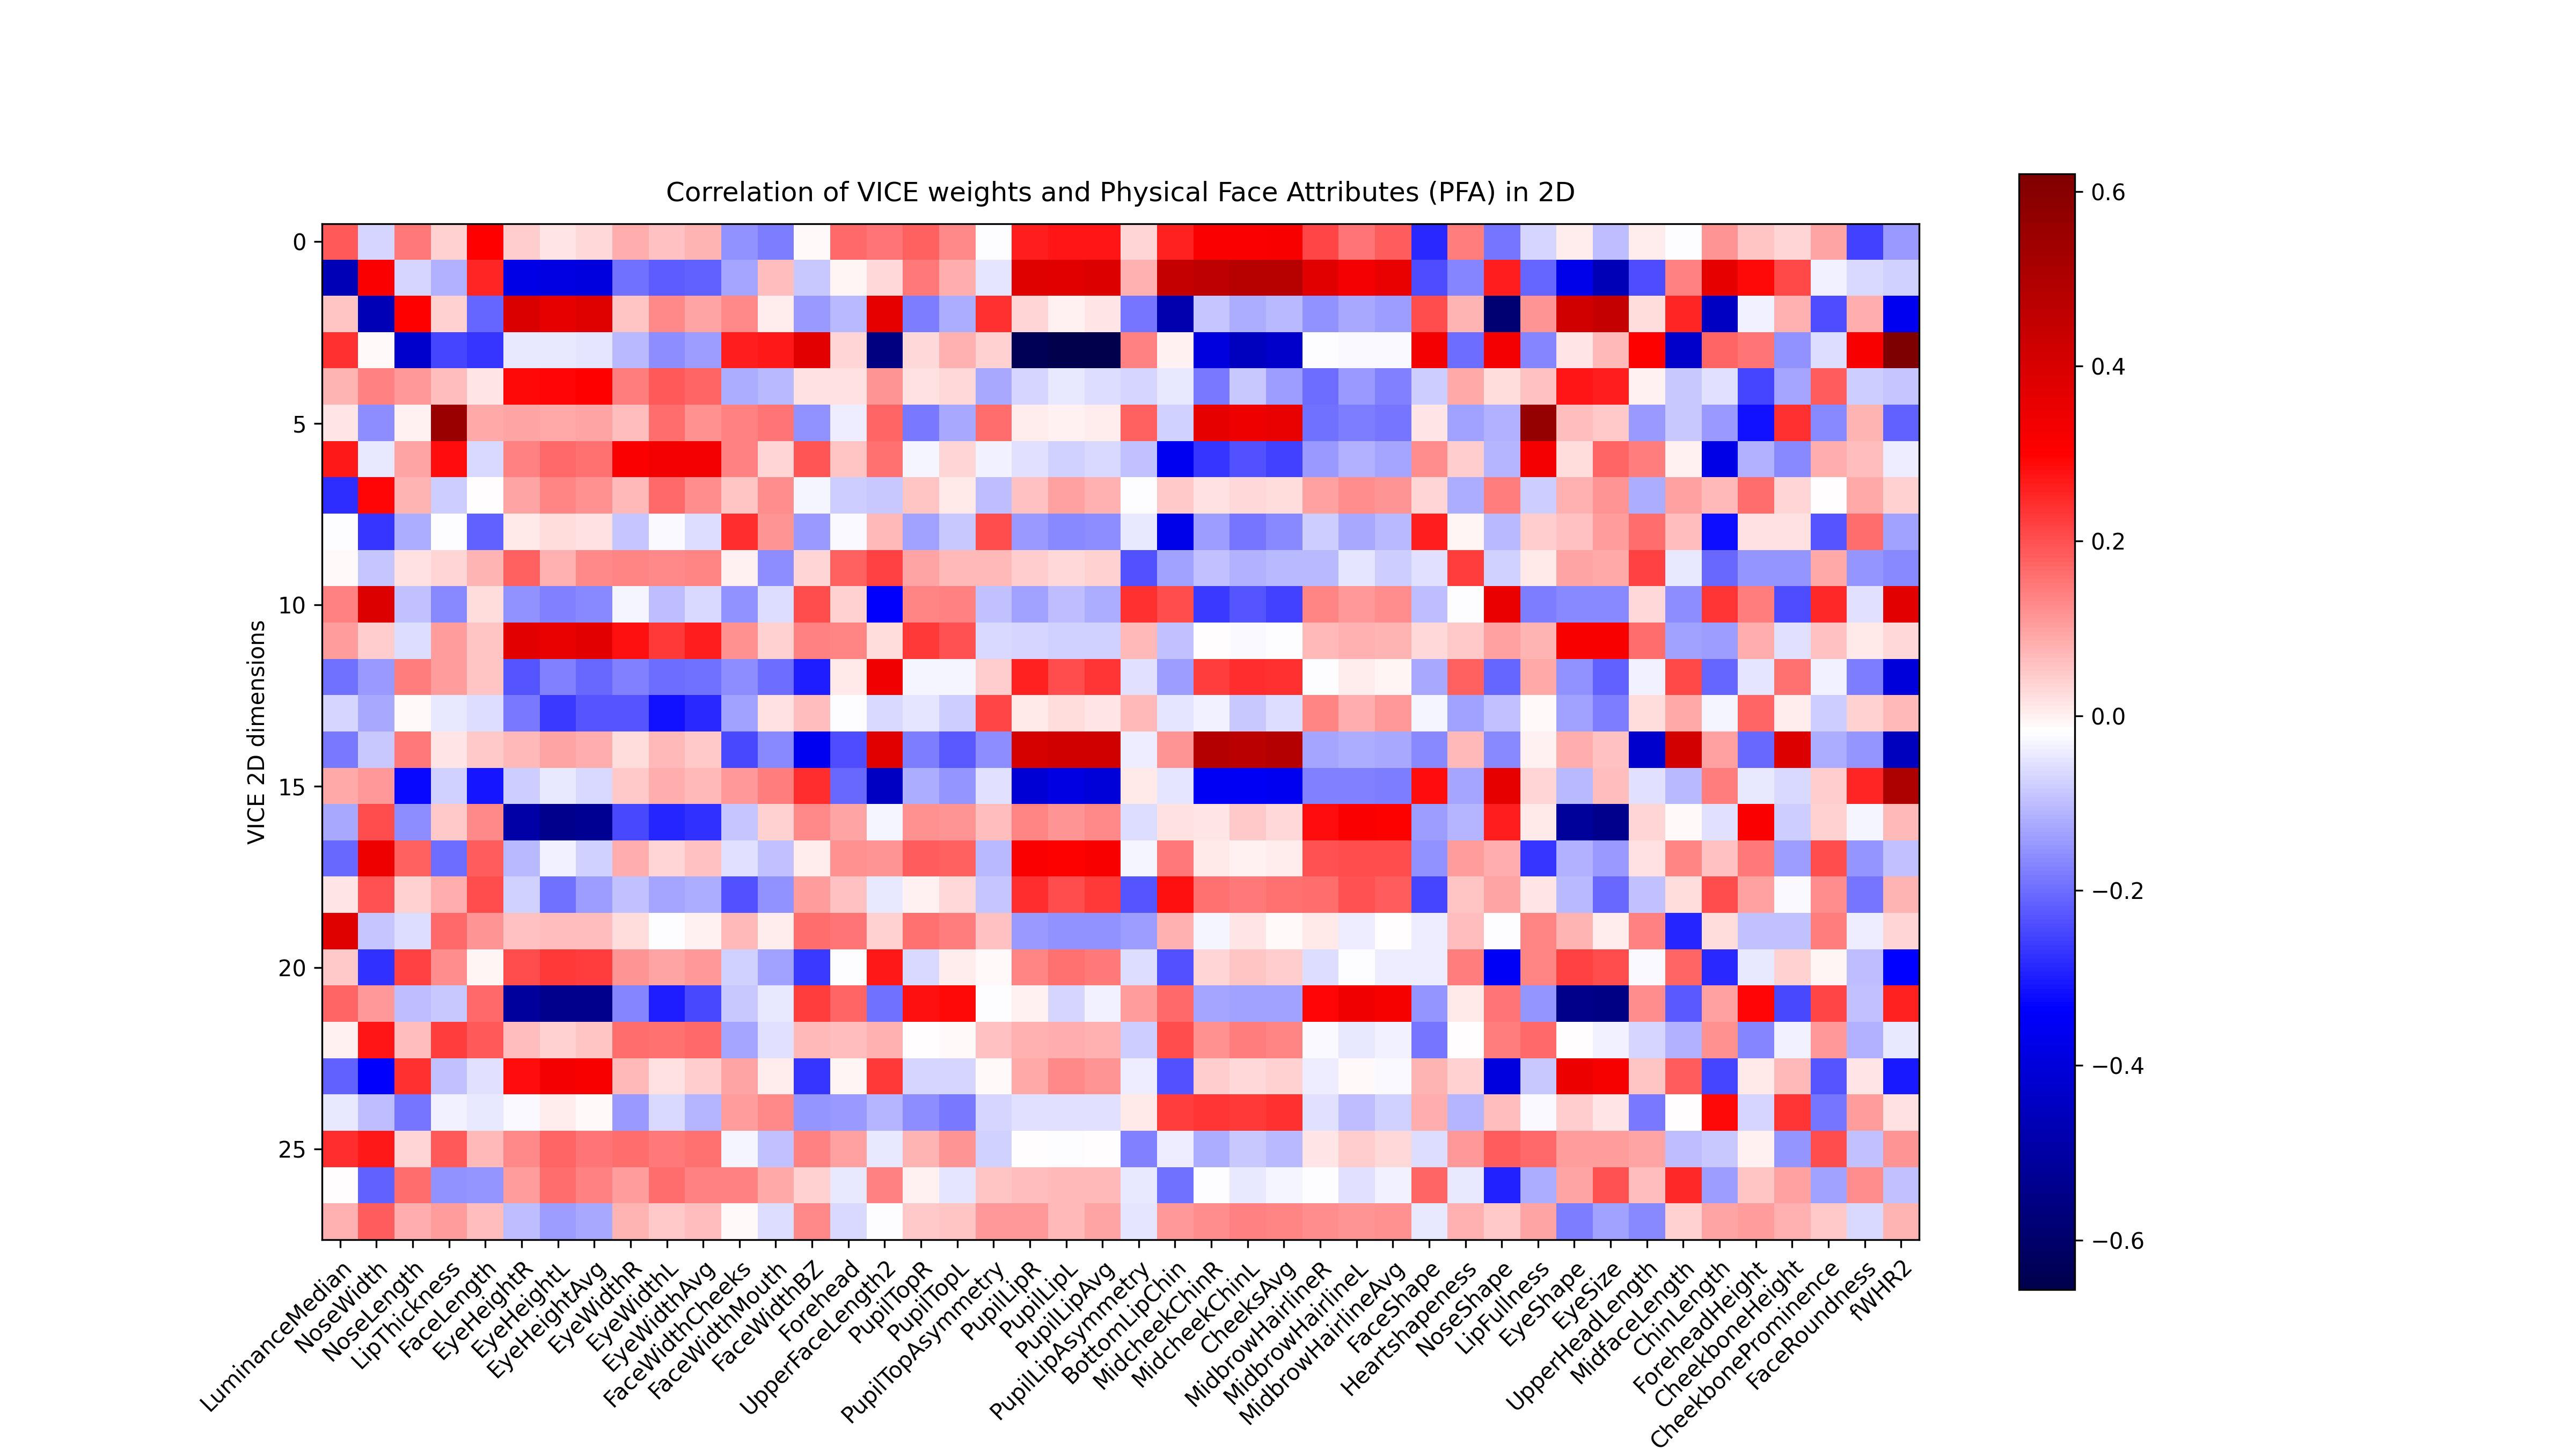

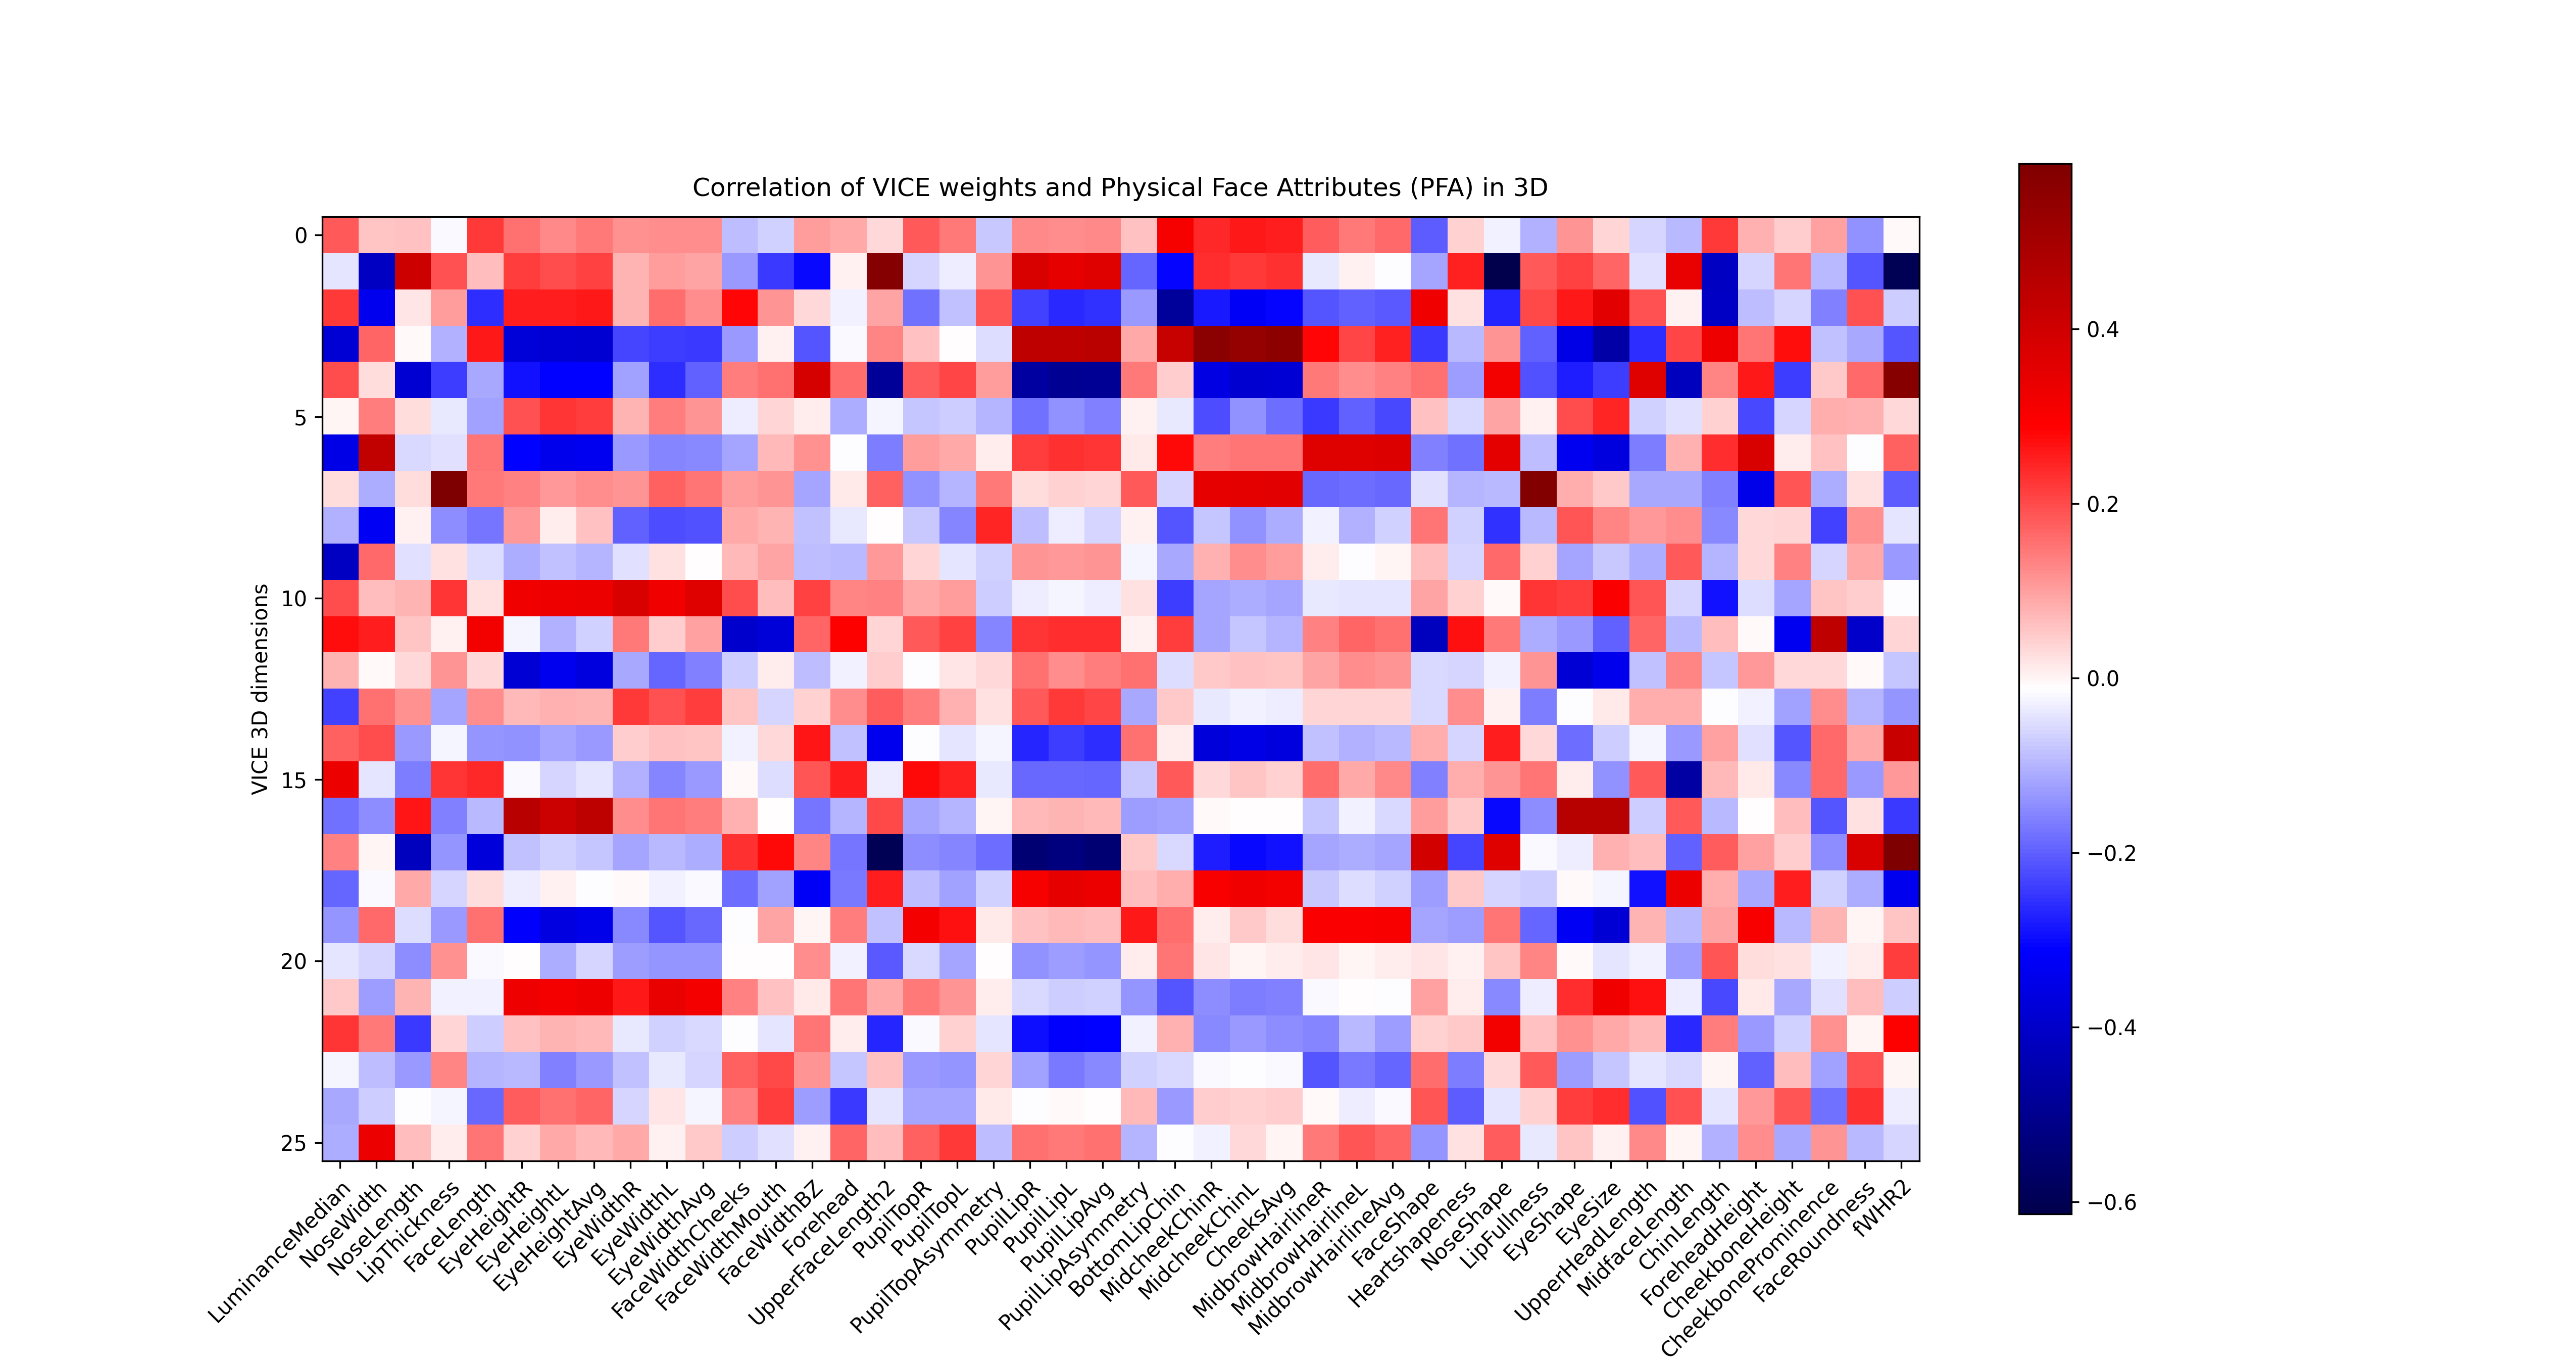

In [33]:
p2_plot_2d = p2_vice_weights_2d.replace("pruned_params.npz", "Correlation of VICE weights and PFA matrix in 2D.png")
p2_plot_3d = p2_vice_weights_3d.replace("pruned_params.npz", "Correlation of VICE weights and PFA matrix in 3D.png")

# 2D
img = Image(p2_plot_2d, width=800)
dspl(img)

# 3D
img = Image(p2_plot_3d, width=800)
dspl(img)

In [34]:
# Iter over VICE dimensions
n_vice_dims = 3
n_pfa = 3  # number of important PFAs to print
cprint(f"{n_pfa} strongest correlations between first {n_vice_dims} VICE dimensions and PFAs", col="b", fm="bo")
for sess, vice_pfa_corr_mat in zip(params.SESSIONS, [vice_pfa_corr_mat_2d, vice_pfa_corr_mat_3d], strict=False):
    for i_dim, vice_dim in enumerate(vice_pfa_corr_mat[:n_vice_dims]):
        cprint(f"\n{sess}-VICE dimension {i_dim + 1}:\n", col="y", fm="ul")
        idx_pfa_importance = np.argsort(np.abs(vice_dim))  # last one highest (abs)
        print("PFA labels\t", *pfa_labels[idx_pfa_importance][-n_pfa:], sep="\t\t")
        print("R\t\t", *np.round(vice_dim[idx_pfa_importance][-n_pfa:], 2), sep="\t\t\t")
    print("\n", "*-" * 47)
# For more details see: "./results/main/logs/computational_choice_model.log"

3 strongest correlations between first 3 VICE dimensions and PFAs

2D-VICE dimension 1:

PFA labels			MidcheekChinR		MidcheekChinL		CheeksAvg
R					0.31			0.31			0.31

2D-VICE dimension 2:

PFA labels			EyeSize		CheeksAvg		MidcheekChinL
R					-0.46			0.48			0.48

2D-VICE dimension 3:

PFA labels			NoseWidth		BottomLipChin		NoseShape
R					-0.47			-0.48			-0.58

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

3D-VICE dimension 1:

PFA labels			CheeksAvg		MidcheekChinL		BottomLipChin
R					0.25			0.26			0.3

3D-VICE dimension 2:

PFA labels			UpperFaceLength2		fWHR2		NoseShape
R					0.57			-0.6			-0.61

3D-VICE dimension 3:

PFA labels			EyeSize		ChinLength		BottomLipChin
R					0.35			-0.41			-0.48

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


## Face attributes
### Gender-specific face attributes: How do PFAs (in CFD) differ between genders?

In [35]:
feat_tab = get_cfd_features_for_models(
    list_of_models=heads_naming_converter_table(pilot_version=None).Model, physical_attr_only=True
).astype(float)
# print(*list(map(cfd_var_converter, feat_tab.columns.to_list())), sep="\n")  # print all PFA vars # noqa: ERA001

# Filter for gender WM / WF
female_feat_tabel = feat_tab.loc[[idx for idx in feat_tab.index if "WF" in idx]]
male_feat_tabel = feat_tab.loc[[idx for idx in feat_tab.index if "WM" in idx]]

# Do women have bigger OR smaller eyes?
eye_size_code = cfd_var_converter("EyeSize").item()
# female_feat_tabel[eye_size_code].hist(bins=15)  # noqa: ERA001
# male_feat_tabel[eye_size_code].hist(bins=15)  # noqa: ERA001
print("Female eye-size:\n", female_feat_tabel[eye_size_code].describe())
print("\nMale eye-size:\n", male_feat_tabel[eye_size_code].describe())
print(f"\n{ttest_ind(a=female_feat_tabel[eye_size_code], b=male_feat_tabel[eye_size_code]) = }")

Female eye-size:
 count    50.000000
mean      0.054131
std       0.006044
min       0.039763
25%       0.051509
50%       0.052956
75%       0.057007
max       0.071462
Name: P056, dtype: float64

Male eye-size:
 count    50.000000
mean      0.048736
std       0.007077
min       0.029462
25%       0.043373
50%       0.049134
75%       0.053614
max       0.061582
Name: P056, dtype: float64

ttest_ind(a=female_feat_tabel[eye_size_code], b=male_feat_tabel[eye_size_code]) = Ttest_indResult(statistic=4.099633006037346, pvalue=8.543611806806524e-05)


## MORE ...
...

In [36]:
pass